In [52]:
import os

folder_path = "/Users/ramonjr.comendador/cs198-protein-folding/datasets"

csv_files = [f for f in os.listdir(folder_path) if (f.endswith('.csv') and not f.endswith('5.csv'))][:]

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [54]:
# FUNCTION FOR INTERPOLATING MATRIX

def interpolate_matrix(matrix, scale_factor):
    interpolated_matrix = scipy.ndimage.zoom(matrix, zoom=scale_factor, order=3)  # cubic interpolation (order=3)
    
    return interpolated_matrix

In [55]:
# CONVERT CSV TO MATRICES

def csv_to_3D_matrix(folder_path, csv_files):
    """
    Converts a list of CSV files into a 3D matrix where each CSV contributes
    a 2D matrix of values based on the 'x', 'y', and 'Value' columns.
    
    Parameters:
    - folder_path (str): The folder where the CSV files are located.
    - csv_files (list): A list of CSV file names to process.
    
    Returns:
    - list: A list of 2D matrices, each corresponding to a CSV file.
    """
    csv_to_3Dmatrix = []

    for csv_file in csv_files:
        # Load the CSV file
        energy_levels = pd.read_csv(os.path.join(folder_path, csv_file), header=None, names=['x', 'y', 'Value'])

        # Get unique x and y values
        unique_x = energy_levels['x'].unique()
        unique_y = energy_levels['y'].unique()

        # Create index mappings for x and y values
        x_index = {val: idx for idx, val in enumerate(unique_x)}
        y_index = {val: idx for idx, val in enumerate(unique_y)}

        # Initialize a matrix filled with NaNs
        matrix = np.full((len(unique_y), len(unique_x)), np.nan)

        # Fill the matrix with values from the CSV
        for _, row in energy_levels.iterrows():
            x_pos = x_index[row['x']]
            y_pos = y_index[row['y']]
            matrix[y_pos, x_pos] = row['Value']

        # Interpolate the matrix by scale factor of 10
        interpolated_matrix = interpolate_matrix(matrix=matrix, scale_factor=10)

        # print("Matrix shape: ", matrix.shape)
        # print("Interpolated Matrix shape: ", interpolated_matrix.shape)

        # Append the matrix to the list
        # csv_to_3Dmatrix.append(matrix)
        csv_to_3Dmatrix.append(interpolated_matrix)
    
    return csv_to_3Dmatrix


In [56]:
# LOCATING LOCAL MINIMA FUNCTION

def find_local_minima(matrix):
    rows, cols = matrix.shape
    local_minima = []

    def get_neighbors(x, y):
        """Get the 8 neighbors of a point (x, y) with wrap-around."""
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                # Apply wrap-around using modulo operator
                nx = (x + dx) % rows
                ny = (y + dy) % cols
                neighbors.append((nx, ny))
        return neighbors

    def is_local_minimum(x, y):
        """Check if (x, y) is a local minimum considering its neighbors."""
        value = matrix[x, y]
        neighbors = get_neighbors(x, y)
        for nx, ny in neighbors:
            if matrix[nx, ny] < value:
                return False
        return True

    def get_flat_region(x, y, visited):
        """Get all points in the flat region starting from (x, y)."""
        flat_points = [(x, y)]
        visited.add((x, y))
        value = matrix[x, y]
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            neighbors = get_neighbors(cx, cy)
            for nx, ny in neighbors:
                if (nx, ny) not in visited and matrix[nx, ny] == value:
                    visited.add((nx, ny))
                    flat_points.append((nx, ny))
                    stack.append((nx, ny))
        return flat_points

    visited = set()

    for x in range(rows):
        for y in range(cols):
            if (x, y) in visited:
                continue
            
            if is_local_minimum(x, y):
                flat_region = get_flat_region(x, y, visited)
                if len(flat_region) > 1:
                    # Find the middle point of the flat region
                    flat_region = np.array(flat_region)
                    mid_idx = len(flat_region) // 2
                    middle_point = tuple(flat_region[mid_idx])
                    local_minima.append(middle_point)
                else:
                    local_minima.append((x, y))

    return local_minima

# Example usage with a random matrix
# local_minima = find_local_minima()
# print("Local minima:", local_minima)


In [57]:
# LOCATING LOCAL MAXIMA FUNCTION

def find_local_maxima(matrix):
    rows, cols = matrix.shape
    local_minima = []

    def get_neighbors(x, y):
        """Get the 8 neighbors of a point (x, y) with wrap-around."""
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                # Apply wrap-around using modulo operator
                nx = (x + dx) % rows
                ny = (y + dy) % cols
                neighbors.append((nx, ny))
        return neighbors

    def is_local_maximum(x, y):
        """Check if (x, y) is a local maximum considering its neighbors."""
        value = matrix[x, y]
        neighbors = get_neighbors(x, y)
        for nx, ny in neighbors:
            if matrix[nx, ny] > value:
                return False
        return True

    def get_flat_region(x, y, visited):
        """Get all points in the flat region starting from (x, y)."""
        flat_points = [(x, y)]
        visited.add((x, y))
        value = matrix[x, y]
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            neighbors = get_neighbors(cx, cy)
            for nx, ny in neighbors:
                if (nx, ny) not in visited and matrix[nx, ny] == value:
                    visited.add((nx, ny))
                    flat_points.append((nx, ny))
                    stack.append((nx, ny))
        return flat_points

    visited = set()

    for x in range(rows):
        for y in range(cols):
            if (x, y) in visited:
                continue
            
            if is_local_maximum(x, y):
                flat_region = get_flat_region(x, y, visited)
                if len(flat_region) > 1:
                    # Find the middle point of the flat region
                    flat_region = np.array(flat_region)
                    mid_idx = len(flat_region) // 2
                    middle_point = tuple(flat_region[mid_idx])
                    local_minima.append(middle_point)
                else:
                    local_minima.append((x, y))

    return local_minima

# Example usage with a random matrix
# local_minima = find_local_minima()
# print("Local minima:", local_minima)


In [58]:
import heapq
import math

# A* with wrap-around on a 3D surface (NxN matrix) with heights
def a_star_wrap_around_surface(surface, start, goal):
    rows, cols = len(surface), len(surface[0])
    
    # Directions: Up, Down, Left, Right, and 4 Diagonals
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), 
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]  # Including diagonals

    def get_neighbors(node):
        x, y = node
        neighbors = []
        for dx, dy in directions:
            nx, ny = (x + dx) % rows, (y + dy) % cols  # Wrap-around using modulo
            neighbors.append((nx, ny))
        return neighbors

    def heuristic(node1, node2):
        x1, y1 = node1
        x2, y2 = node2
        h1 = surface[x1][y1]
        h2 = surface[x2][y2]
        # Wrap-around Euclidean distance heuristic, considering height
        dx = min(abs(x1 - x2), rows - abs(x1 - x2))
        dy = min(abs(y1 - y2), cols - abs(y1 - y2))
        dz = abs(h1 - h2)
        return math.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

    def distance(current, neighbor):
        # Euclidean distance between two points, considering height difference
        x1, y1 = current
        x2, y2 = neighbor
        dx = min(abs(x1 - x2), rows - abs(x1 - x2))
        dy = min(abs(y1 - y2), cols - abs(y1 - y2))
        dz = abs(surface[x1][y1] - surface[x2][y2])
        return math.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

    open_list = []
    heapq.heappush(open_list, (0, start))  # Priority queue (f-cost, node)
    came_from = {}
    g_score = {start: 0}
    
    while open_list:
        _, current = heapq.heappop(open_list)
        
        if current == goal:
            # Reconstruct the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path
        
        for neighbor in get_neighbors(current):
            tentative_g_score = g_score[current] + distance(current, neighbor)
            
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(open_list, (f_score, neighbor))
    
    return None  # Return None if no path is found

# Example usage:
# A 5x5 grid where each value represents a height (z-coordinate) of a 3D surface
surface = [
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [1, 2, 3, 4, 5]
]
start = (0, 0)
goal = (4, 4)
path = a_star_wrap_around_surface(surface, start, goal)
print("Path found:", path)


Path found: [(4, 4)]


Local Minima:  (249, 15)


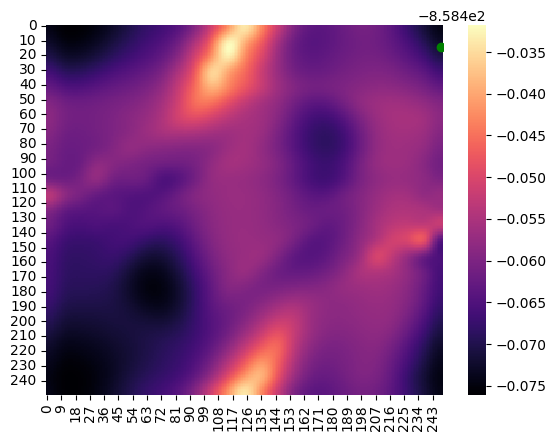

Local Minima:  (11, 169)


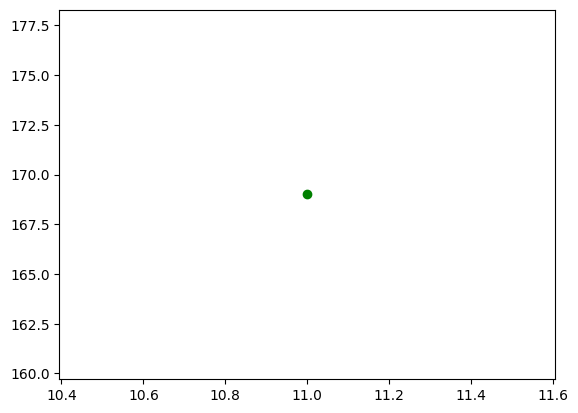

Local Minima:  (78, 175)


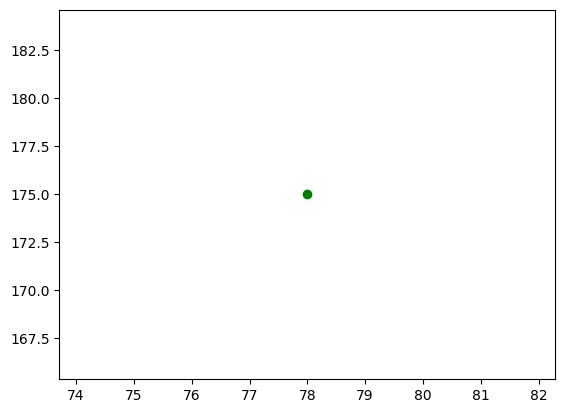

Local Minima:  (94, 14)


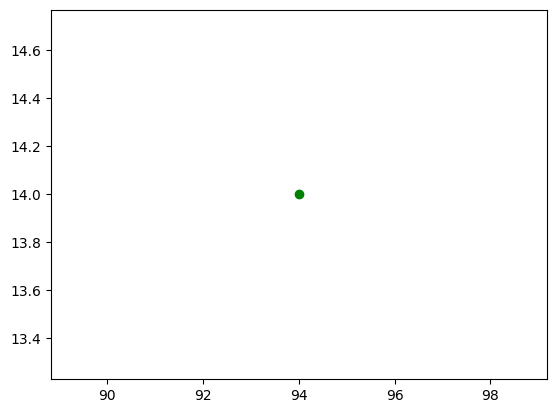

Local Minima:  (106, 74)


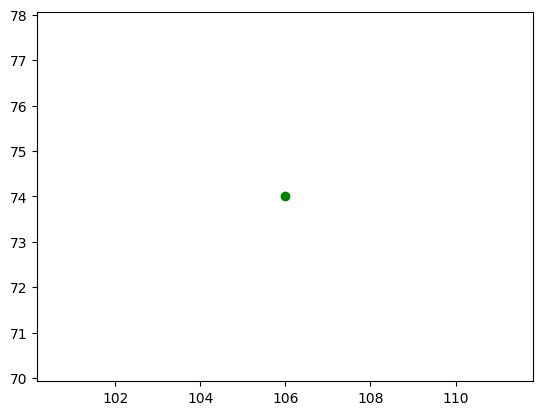

Local Minima:  (121, 56)


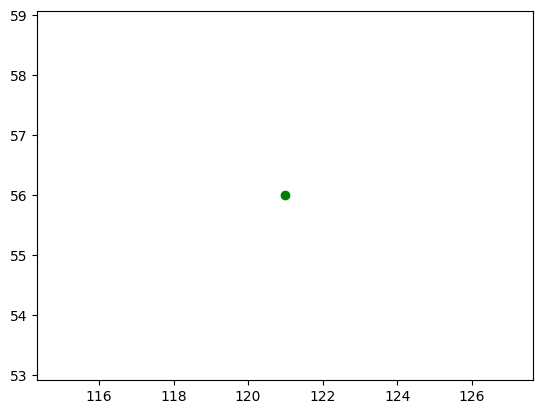

Local Minima:  (150, 249)


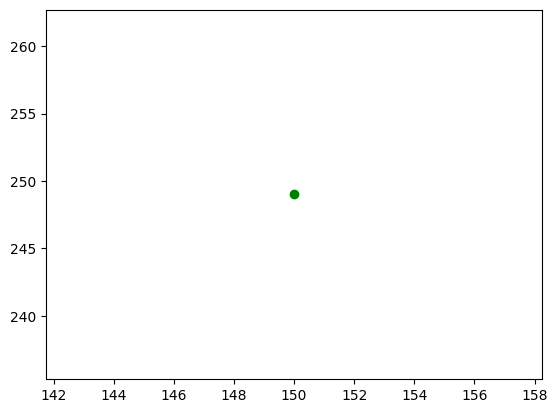

Local Minima:  (151, 169)


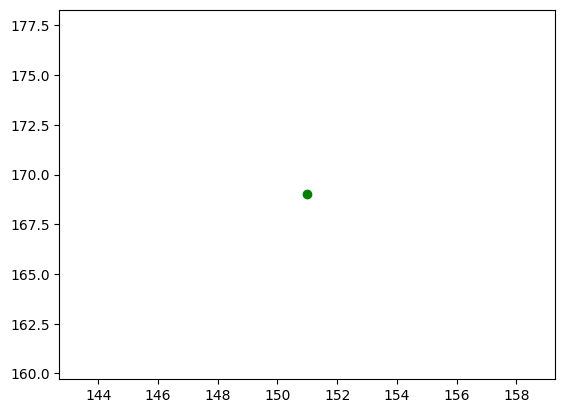

Local Minima:  (177, 67)


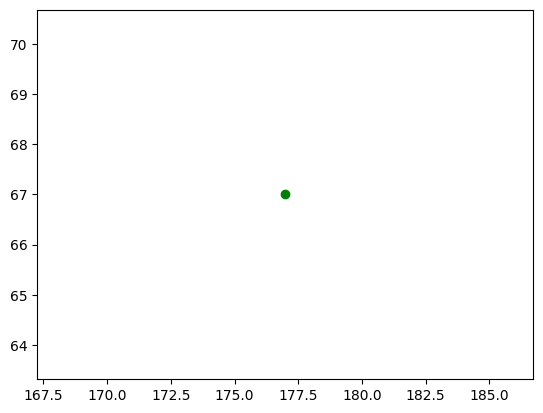

Local Minima:  (241, 15)


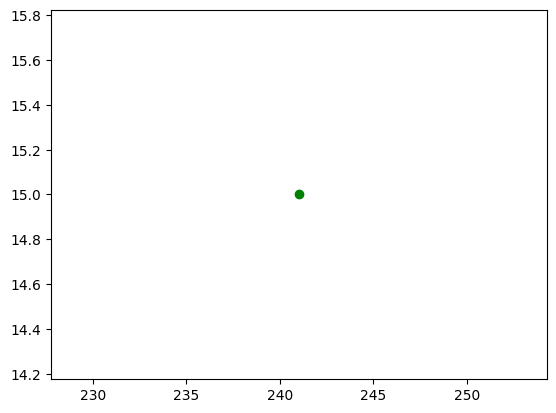

Local Minima:  (0, 17)


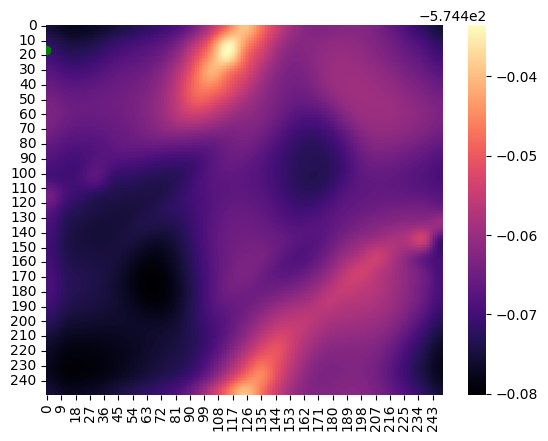

Local Minima:  (99, 14)


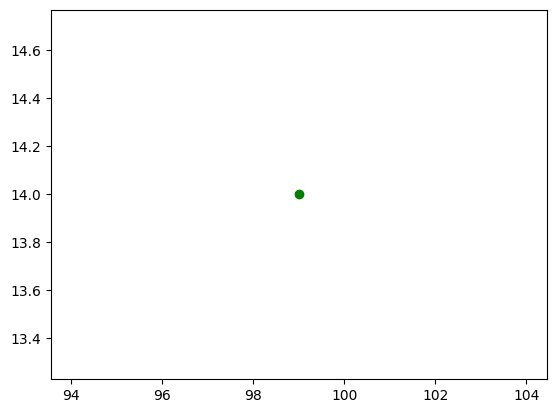

Local Minima:  (101, 168)


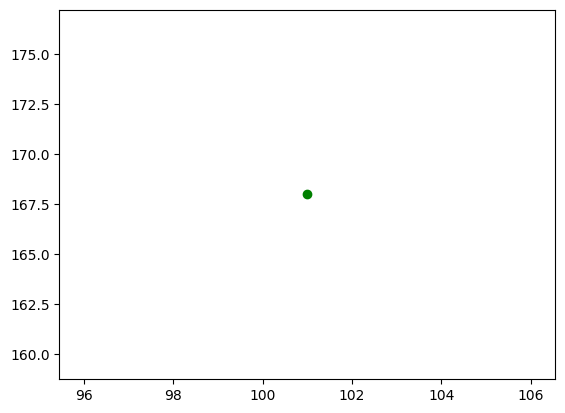

Local Minima:  (140, 34)


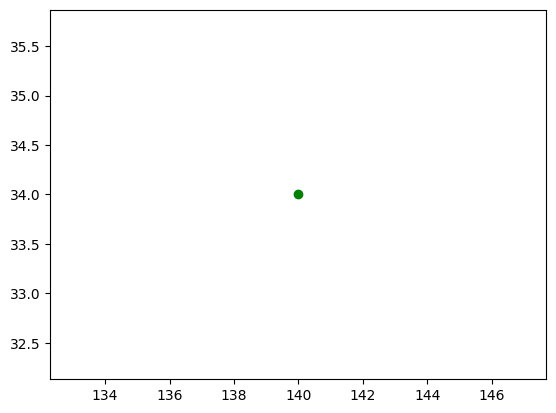

Local Minima:  (149, 249)


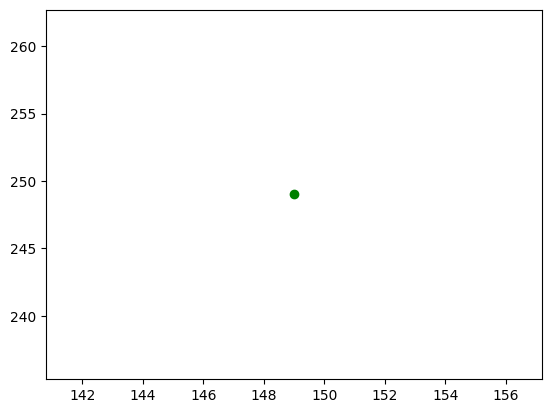

Local Minima:  (156, 158)


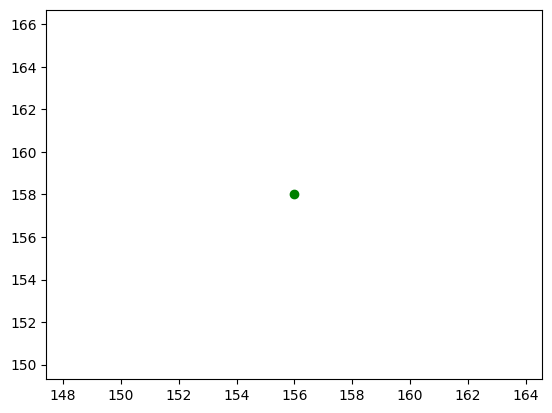

Local Minima:  (174, 66)


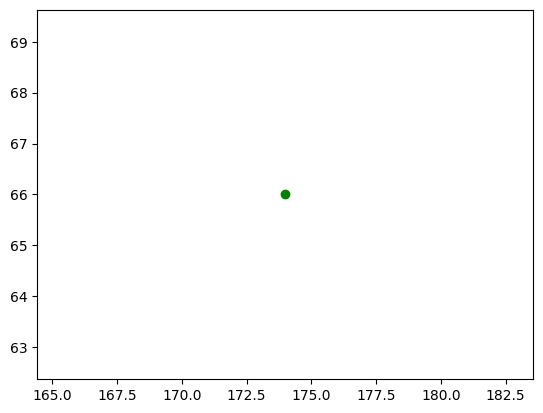

Local Minima:  (232, 17)


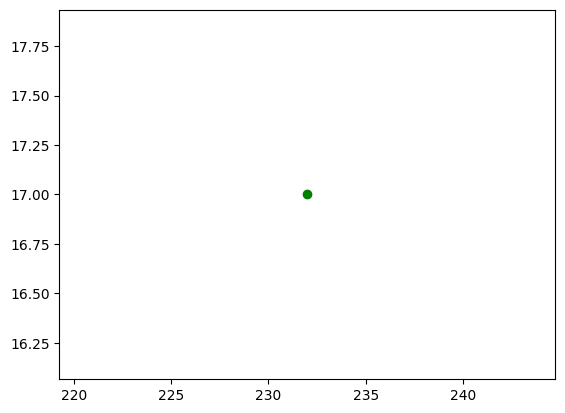

Local Minima:  (232, 249)


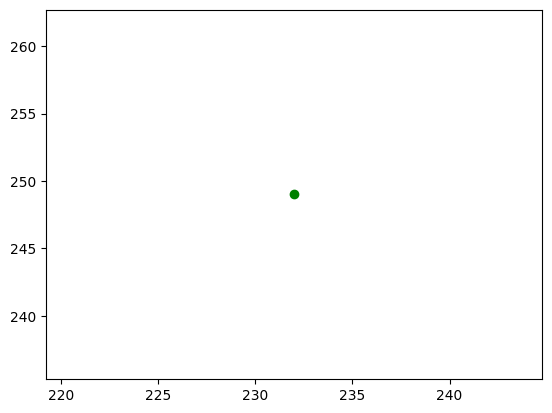

Local Minima:  (236, 177)


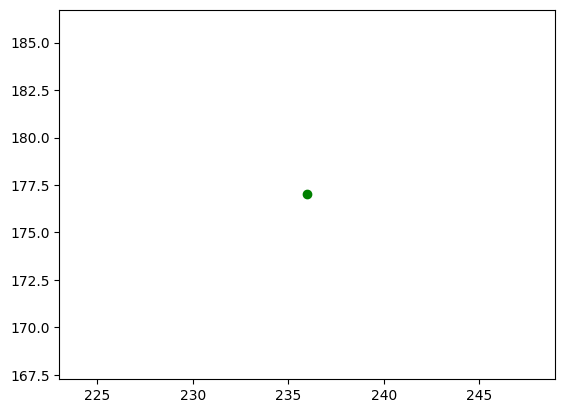

Local Minima:  (0, 15)


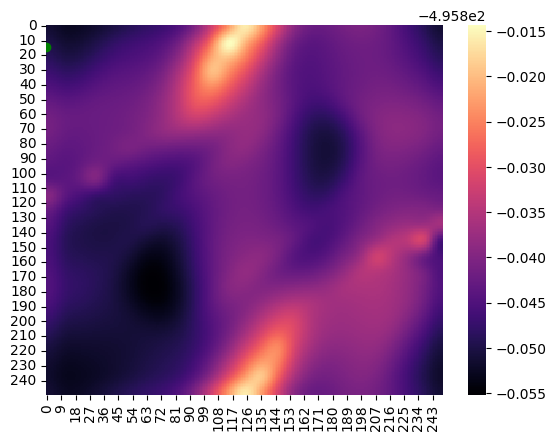

Local Minima:  (85, 176)


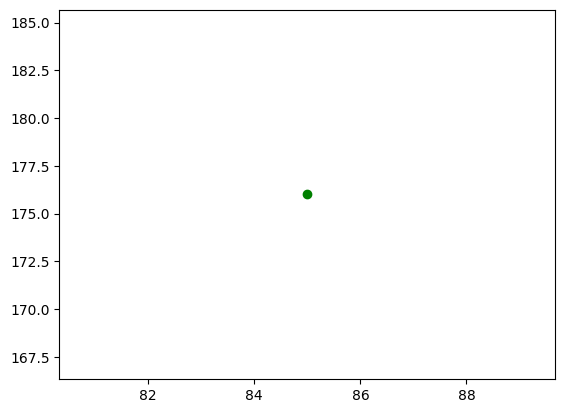

Local Minima:  (100, 0)


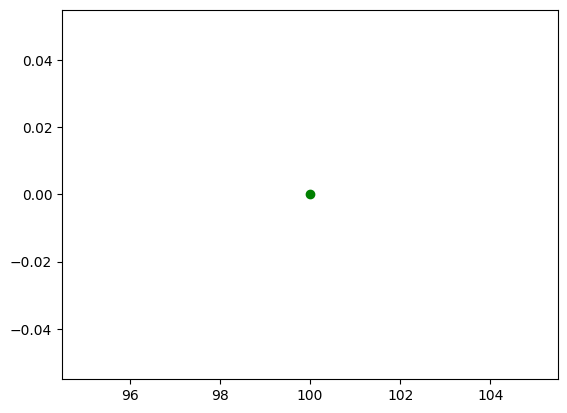

Local Minima:  (140, 36)


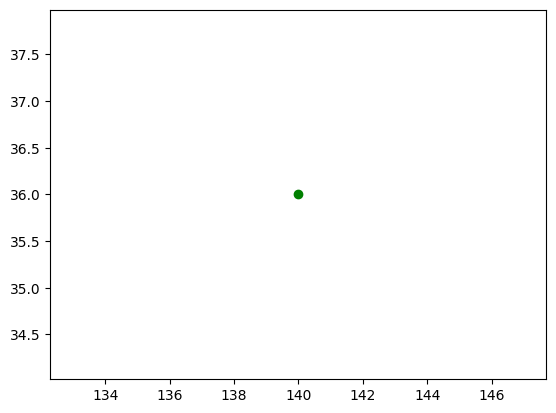

Local Minima:  (146, 170)


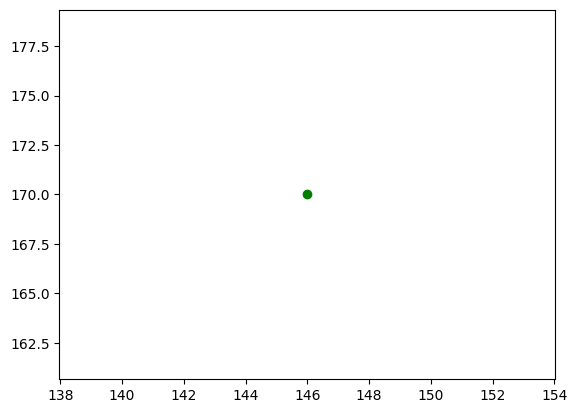

Local Minima:  (149, 249)


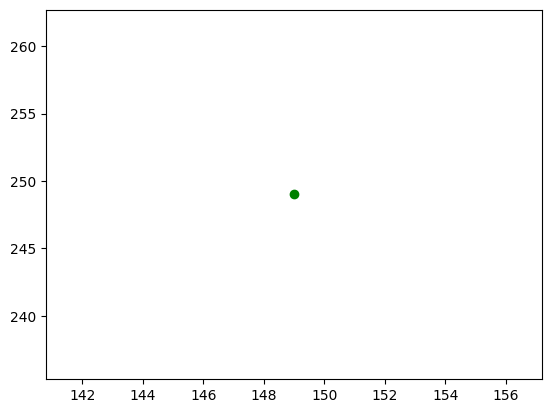

Local Minima:  (175, 67)


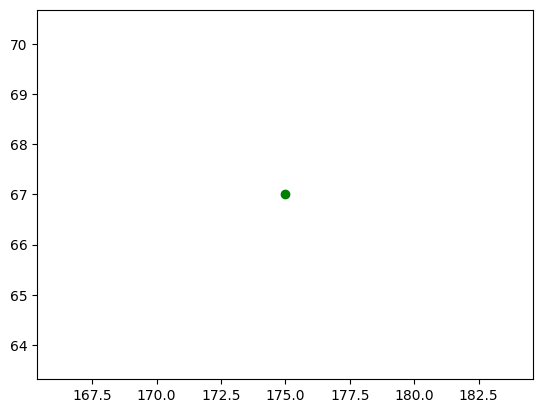

Local Minima:  (236, 249)


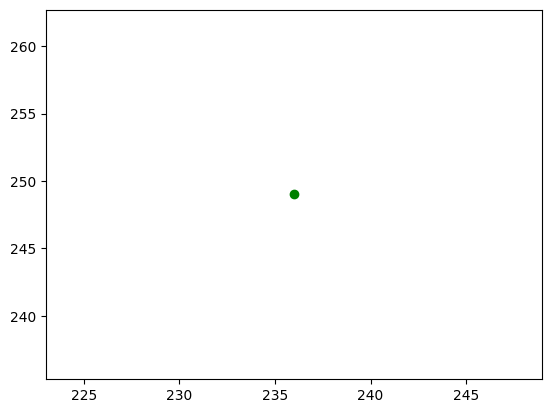

Local Minima:  (237, 15)


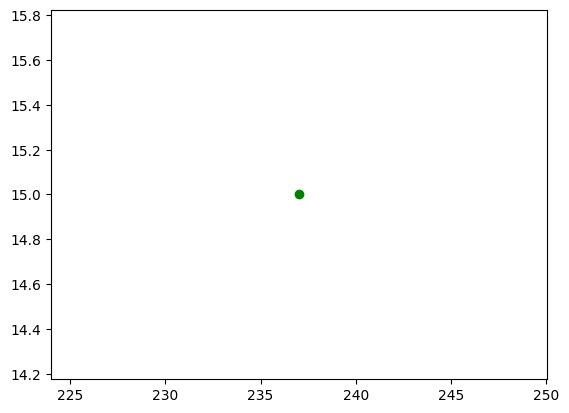

Local Minima:  (0, 14)


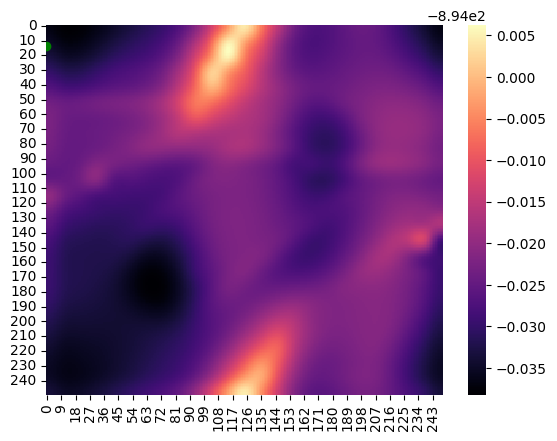

Local Minima:  (0, 249)


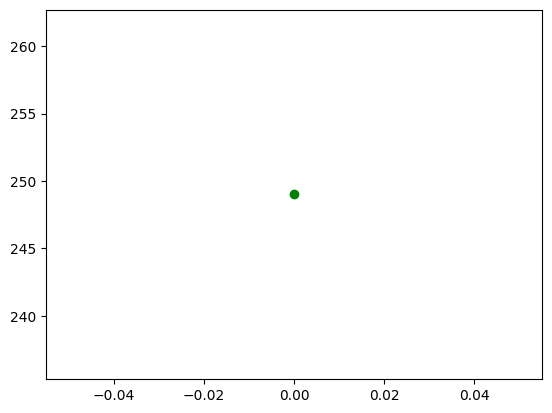

Local Minima:  (11, 169)


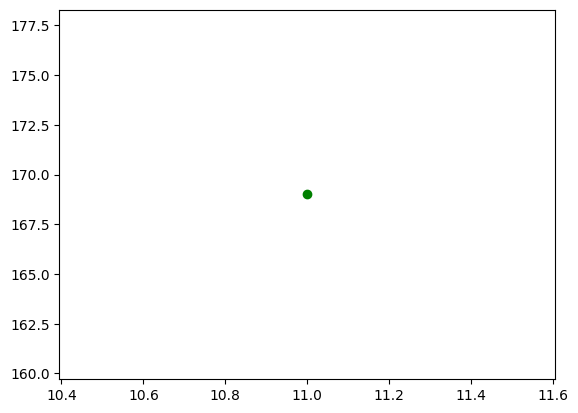

Local Minima:  (70, 19)


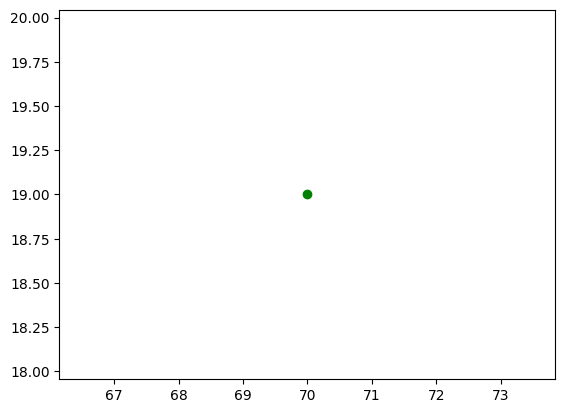

Local Minima:  (79, 175)


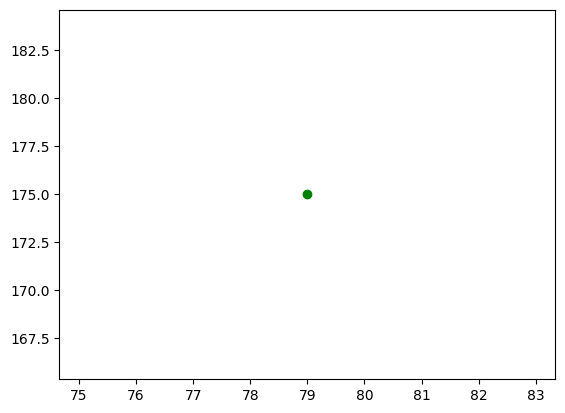

Local Minima:  (100, 0)


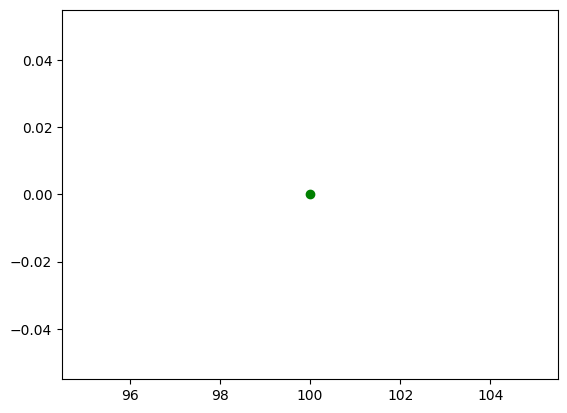

Local Minima:  (105, 173)


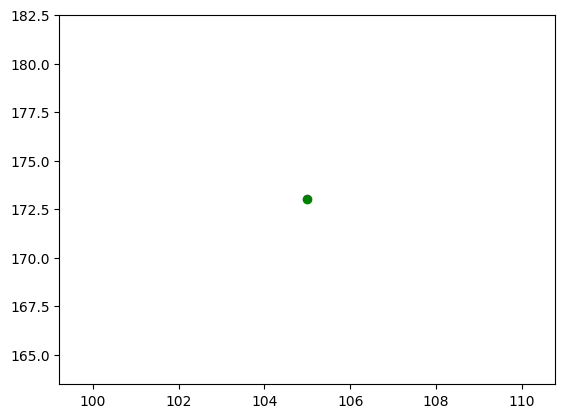

Local Minima:  (150, 168)


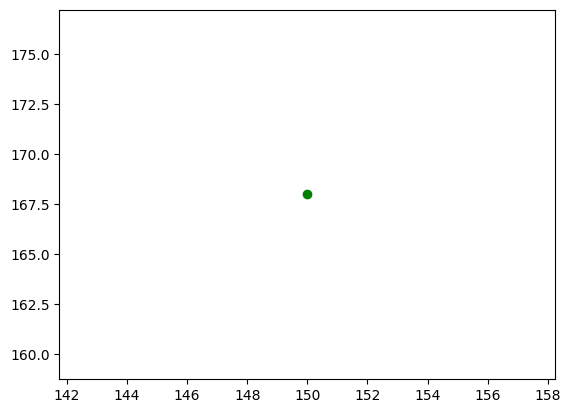

Local Minima:  (150, 249)


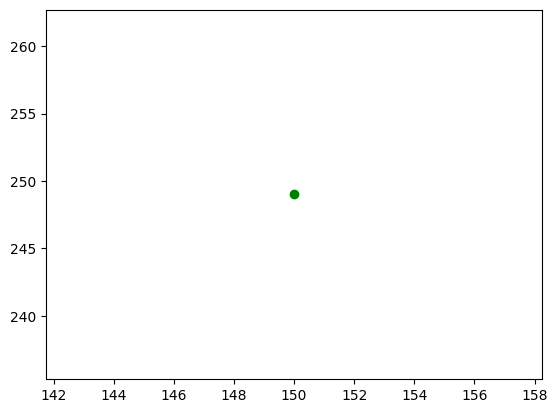

Local Minima:  (175, 67)


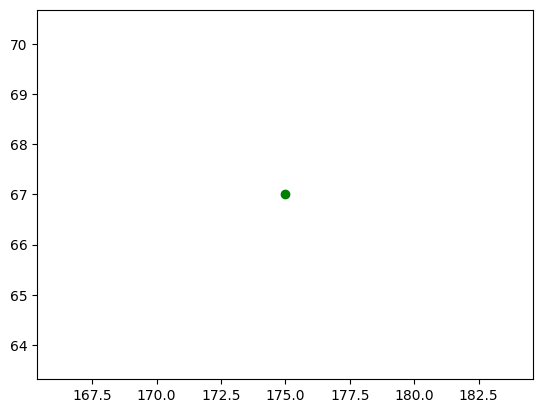

Local Minima:  (192, 183)


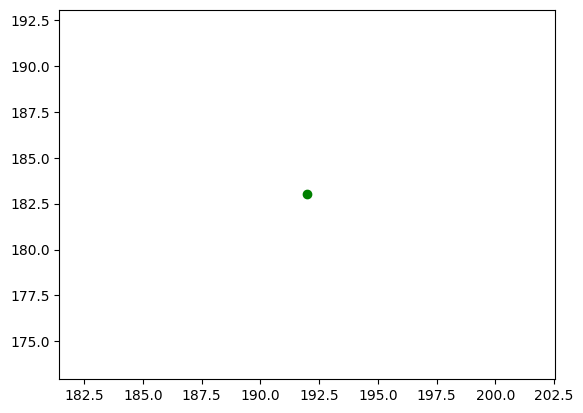

Local Minima:  (233, 249)


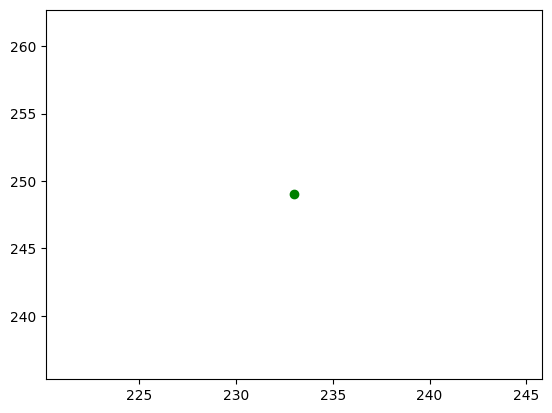

Local Minima:  (234, 14)


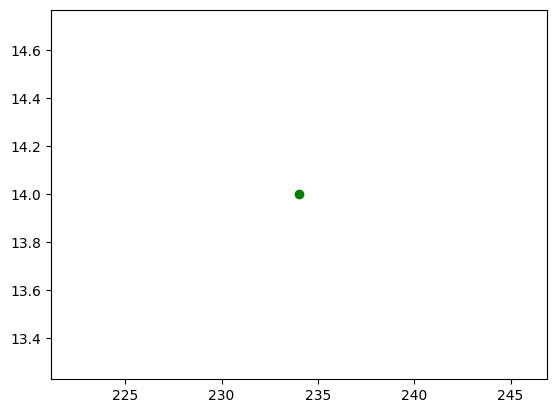

Local Minima:  (0, 16)


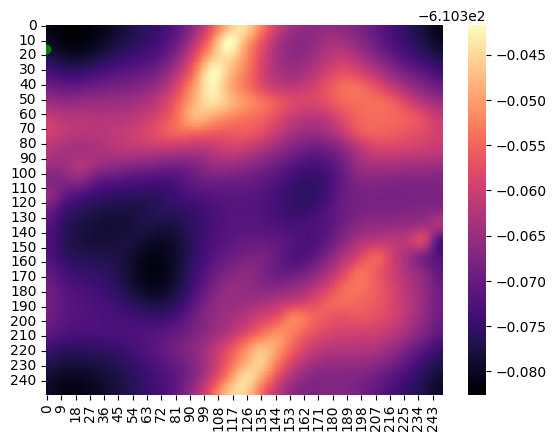

Local Minima:  (0, 0)


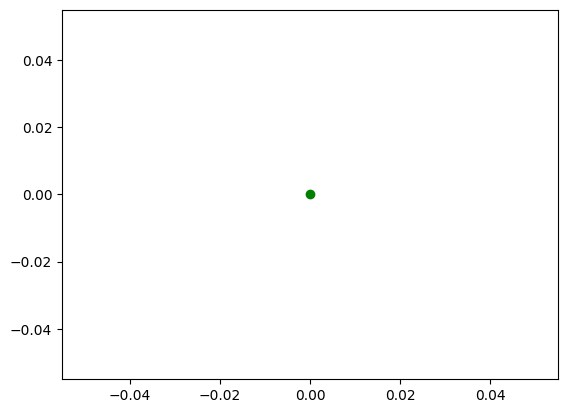

Local Minima:  (13, 159)


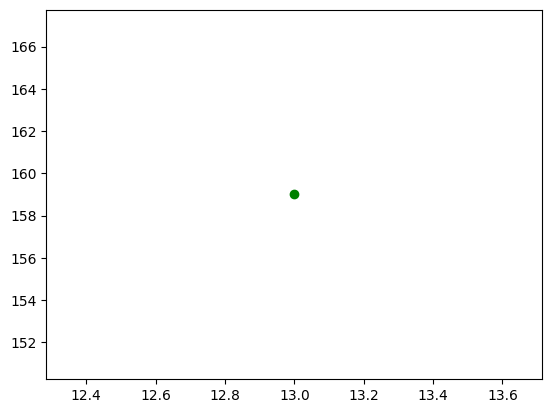

Local Minima:  (83, 20)


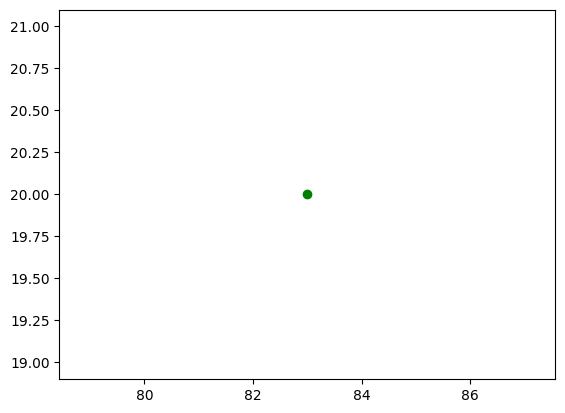

Local Minima:  (113, 163)


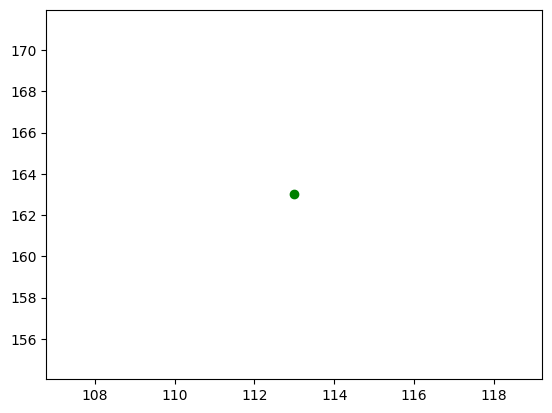

Local Minima:  (116, 218)


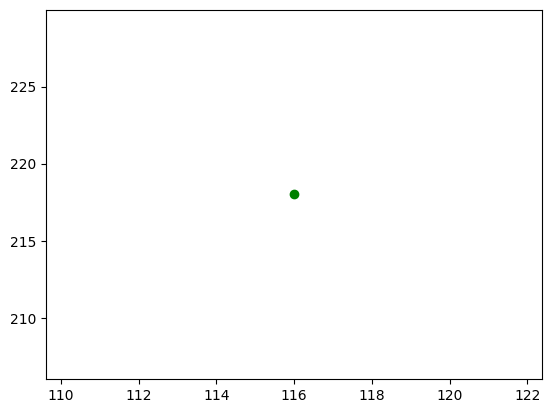

Local Minima:  (116, 249)


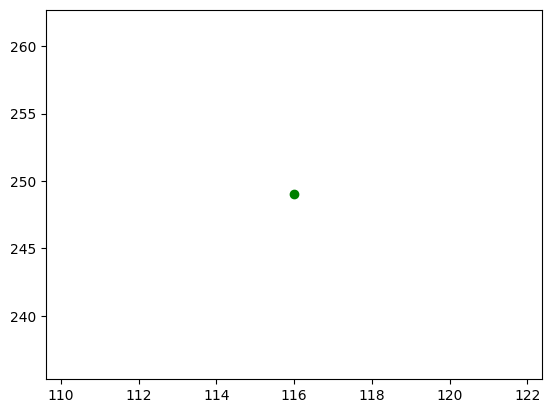

Local Minima:  (139, 38)


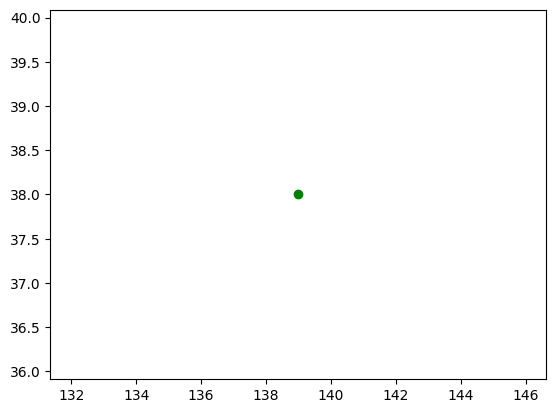

Local Minima:  (149, 249)


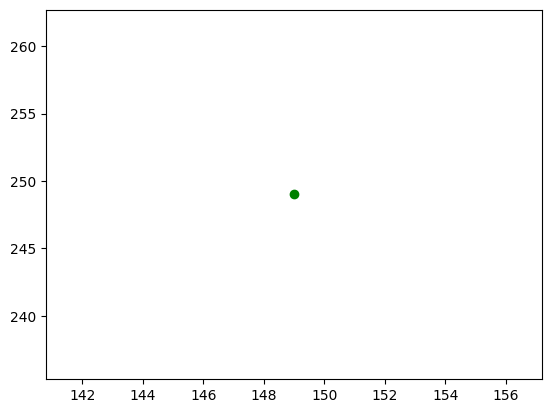

Local Minima:  (164, 67)


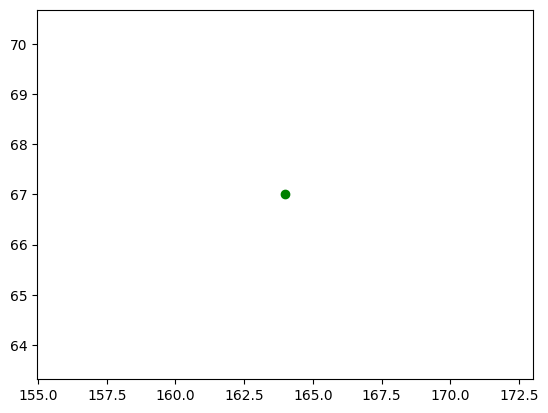

Local Minima:  (249, 167)


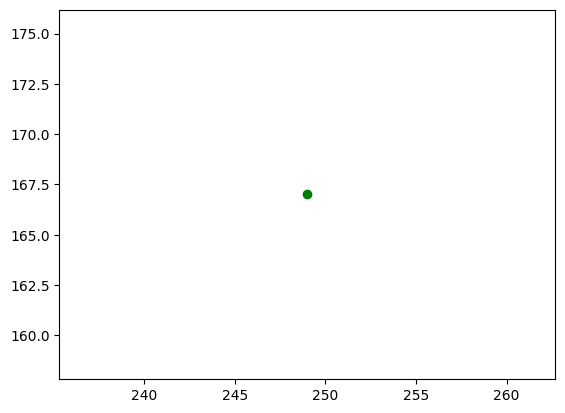

Local Minima:  (0, 15)


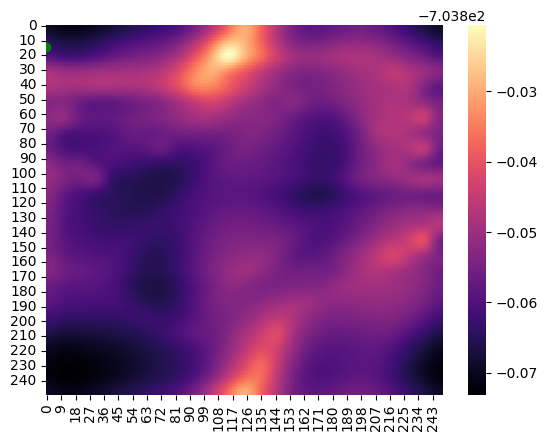

Local Minima:  (0, 0)


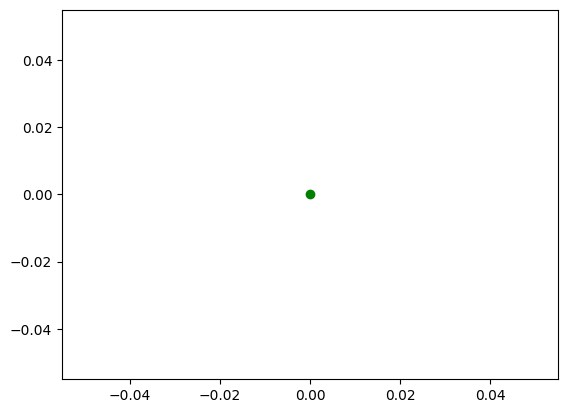

Local Minima:  (43, 249)


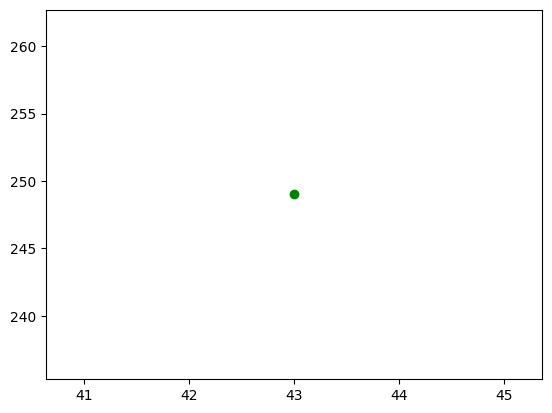

Local Minima:  (55, 34)


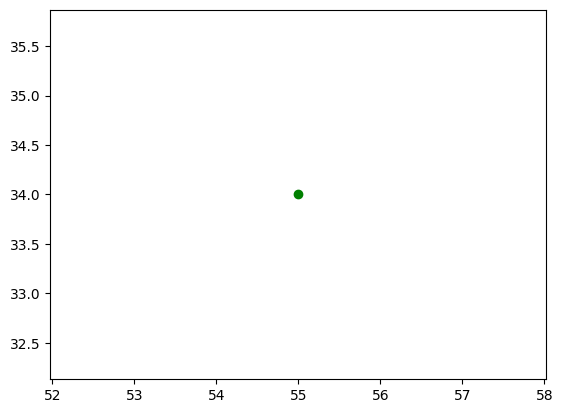

Local Minima:  (79, 18)


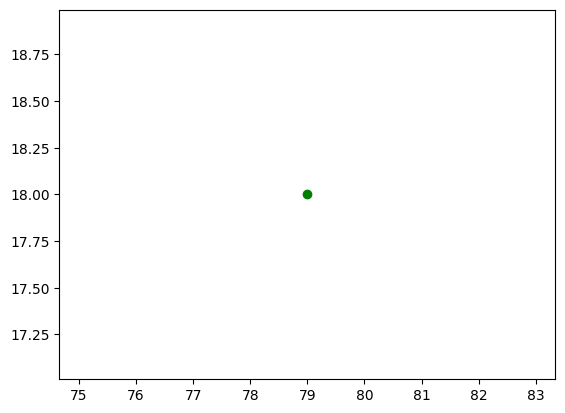

Local Minima:  (90, 176)


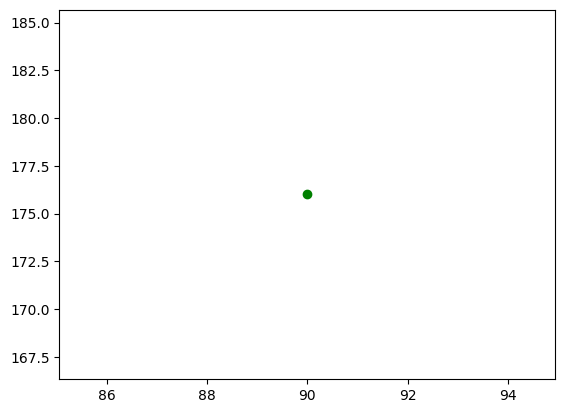

Local Minima:  (90, 249)


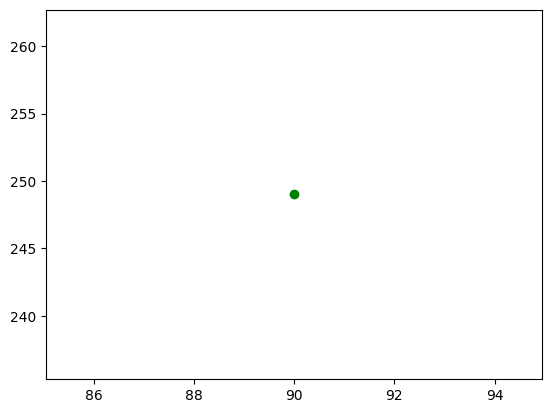

Local Minima:  (109, 68)


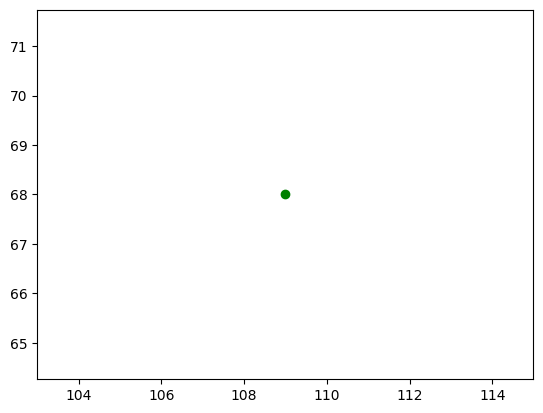

Local Minima:  (114, 171)


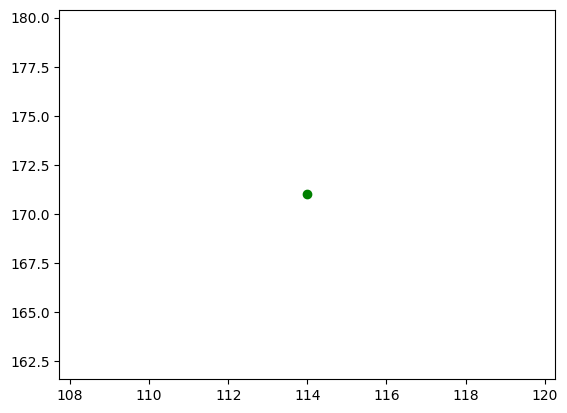

Local Minima:  (116, 249)


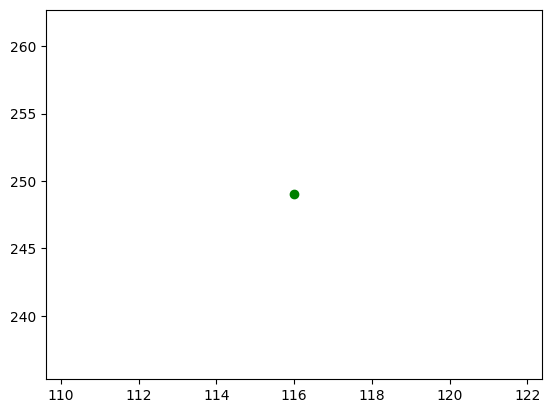

Local Minima:  (148, 249)


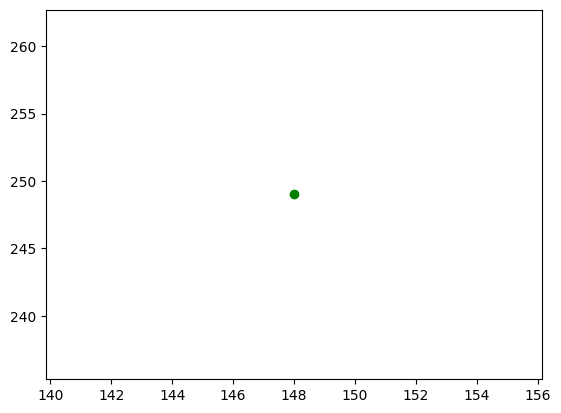

Local Minima:  (177, 67)


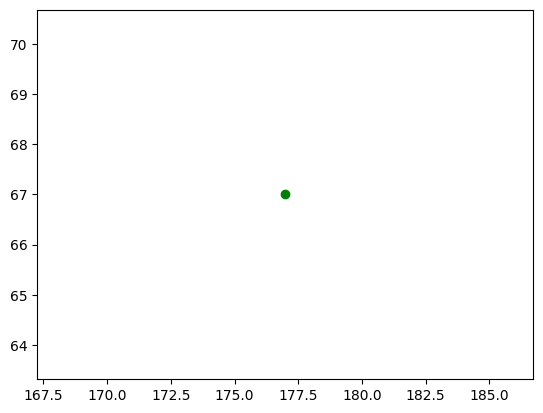

Local Minima:  (234, 14)


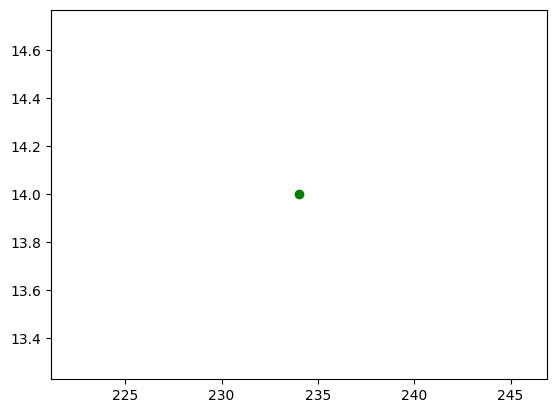

Local Minima:  (234, 175)


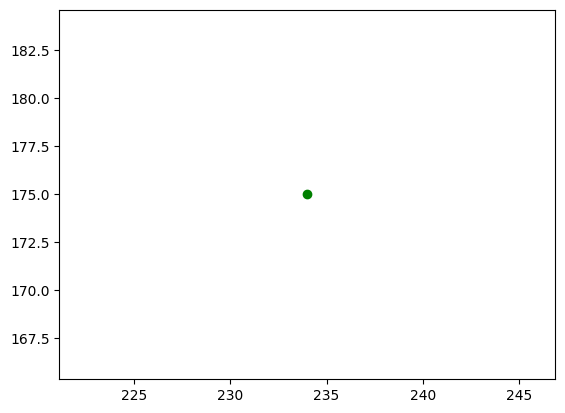

Local Minima:  (234, 249)


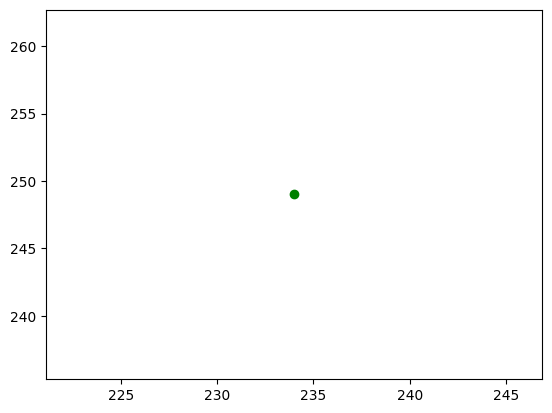

Local Minima:  (0, 15)


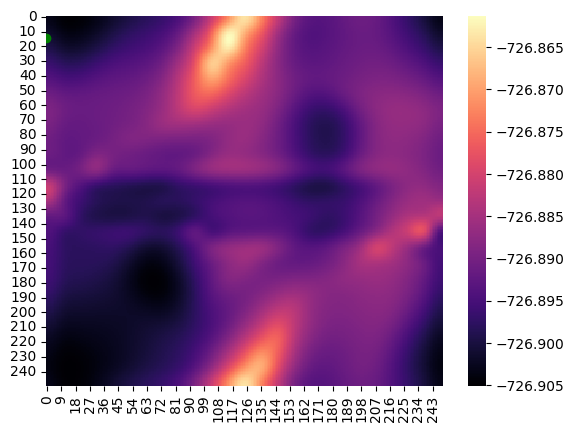

Local Minima:  (0, 249)


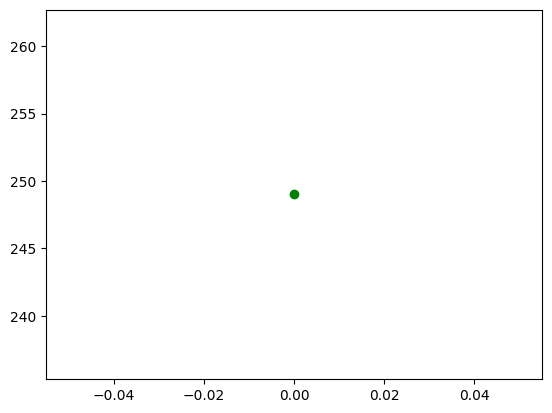

Local Minima:  (12, 169)


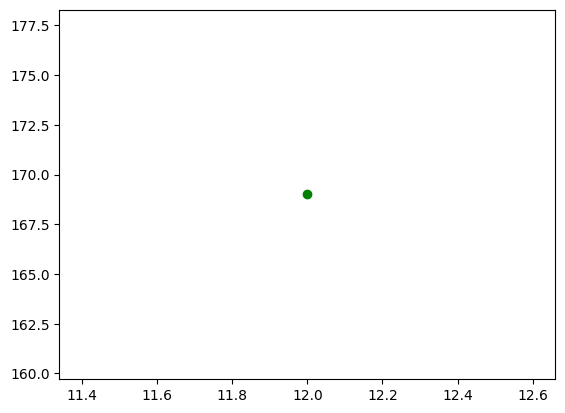

Local Minima:  (78, 175)


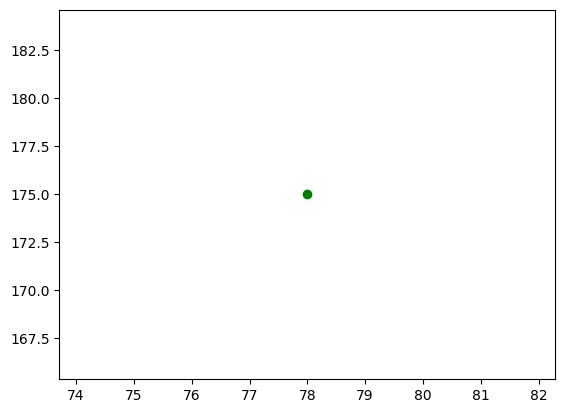

Local Minima:  (89, 16)


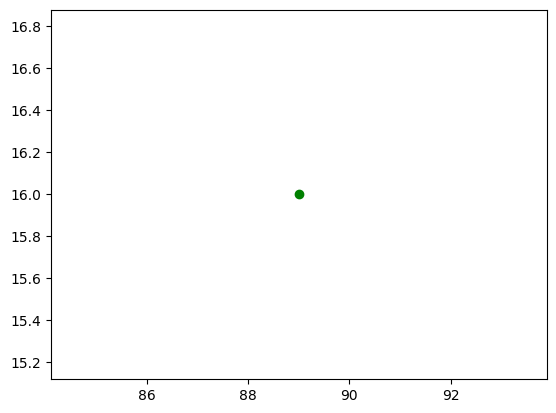

Local Minima:  (95, 78)


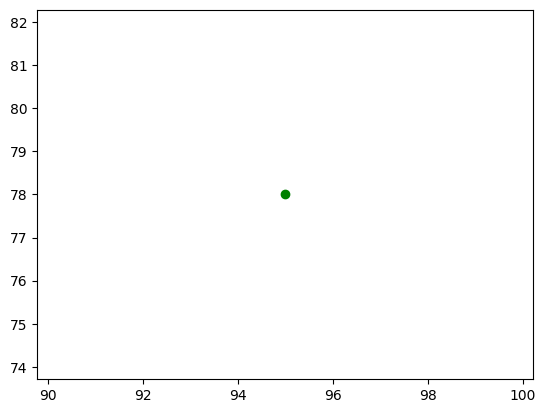

Local Minima:  (116, 171)


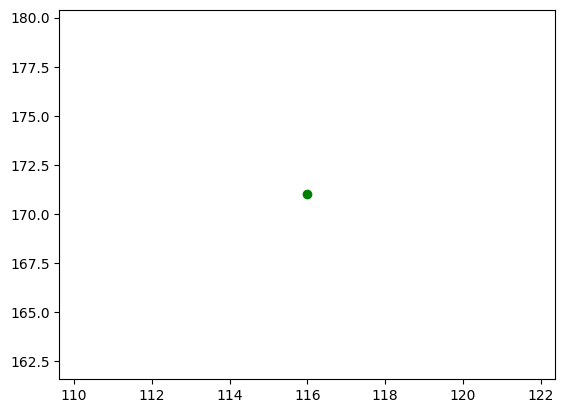

Local Minima:  (118, 62)


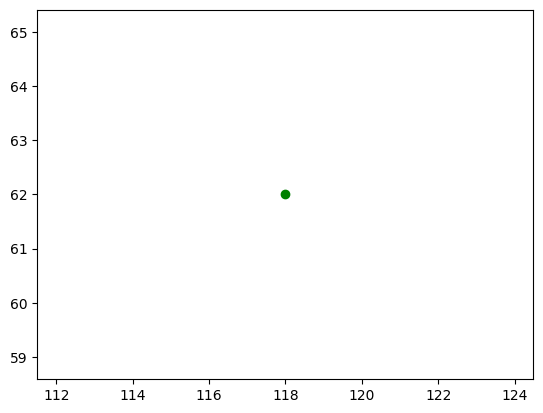

Local Minima:  (132, 45)


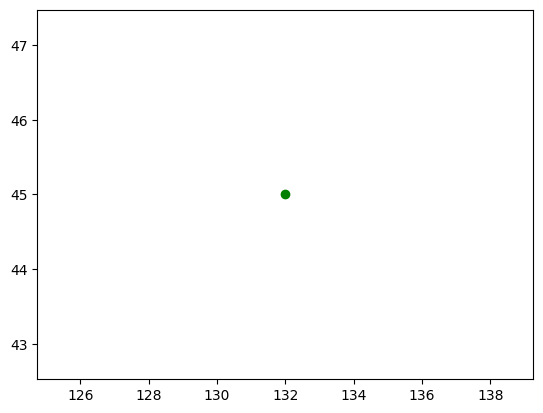

Local Minima:  (135, 75)


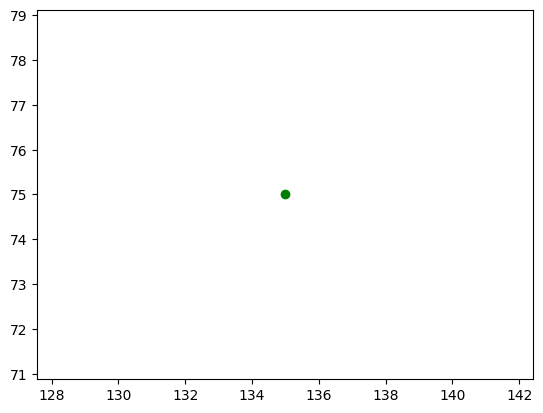

Local Minima:  (140, 104)


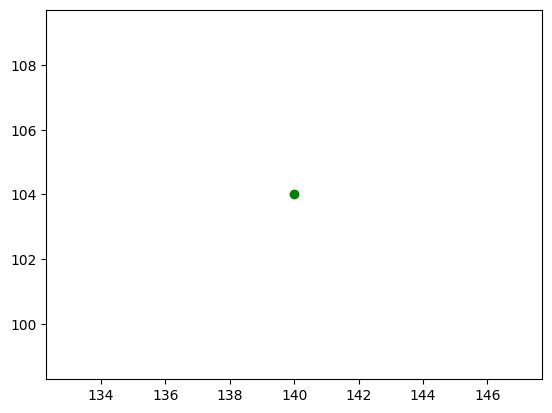

Local Minima:  (141, 175)


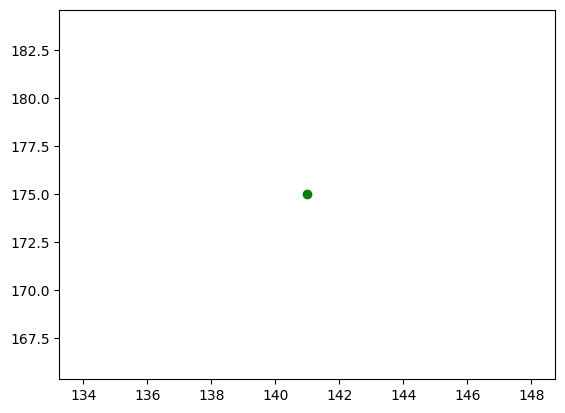

Local Minima:  (150, 249)


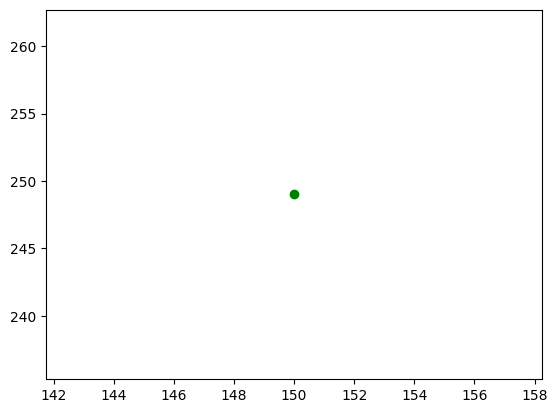

Local Minima:  (179, 67)


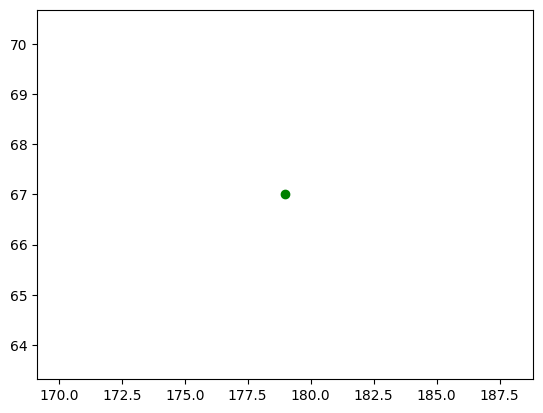

Local Minima:  (236, 249)


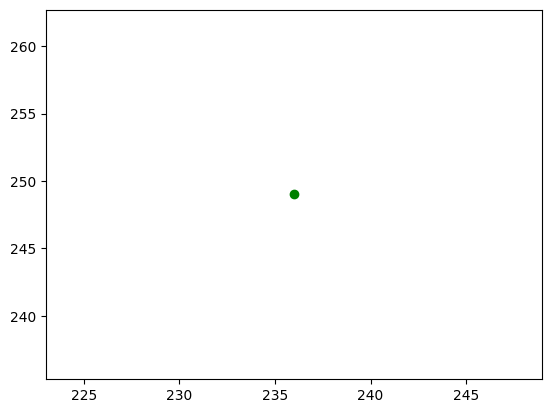

Local Minima:  (238, 14)


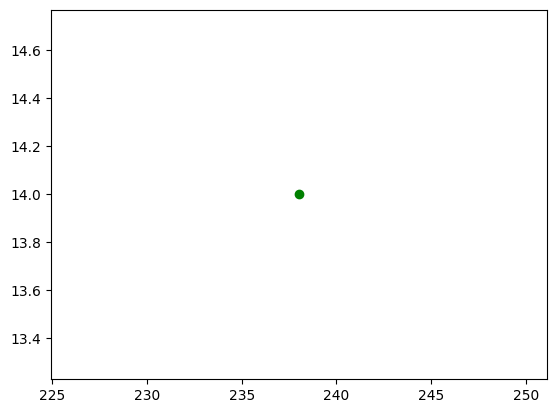

Local Minima:  (0, 0)


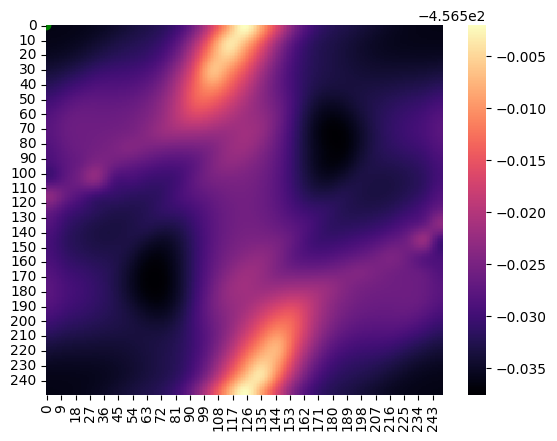

Local Minima:  (75, 182)


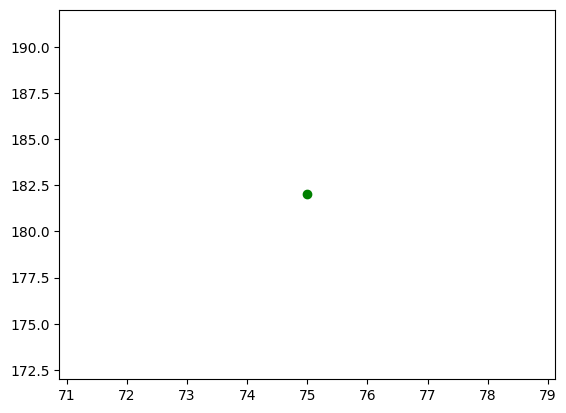

Local Minima:  (100, 0)


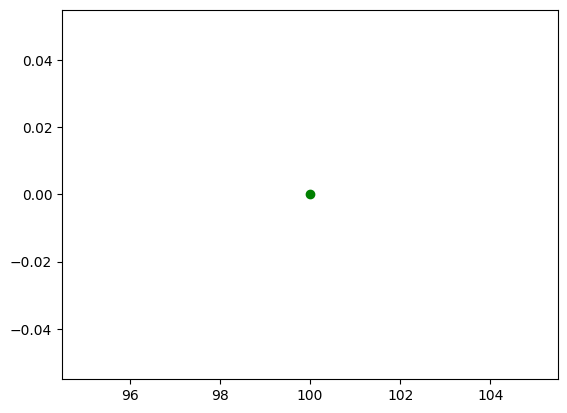

Local Minima:  (109, 210)


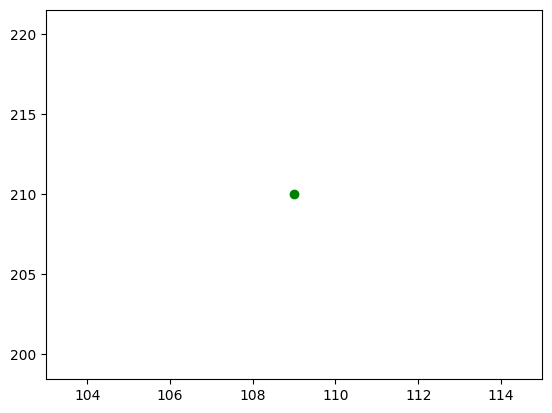

Local Minima:  (140, 39)


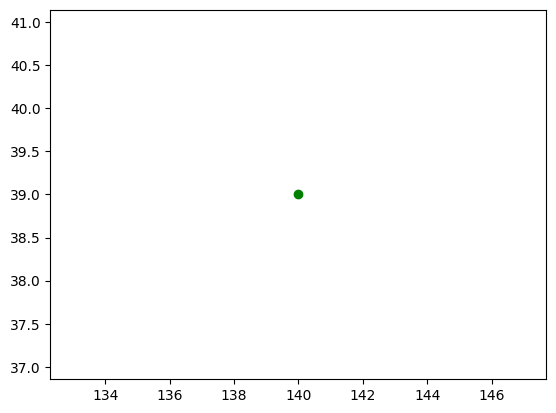

Local Minima:  (149, 249)


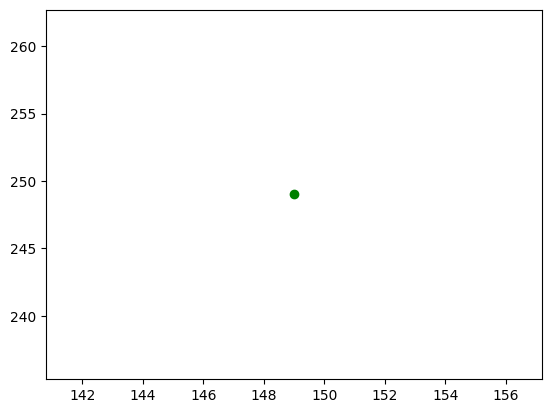

Local Minima:  (172, 68)


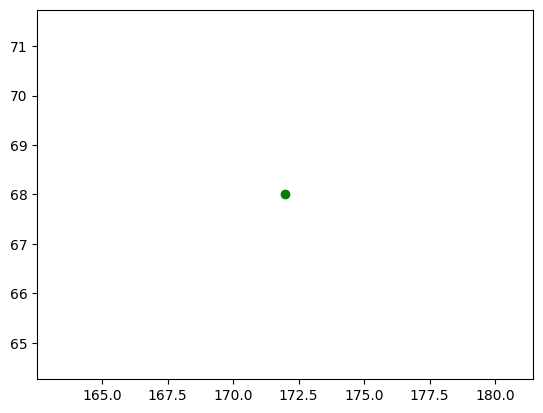

Local Minima:  (0, 0)


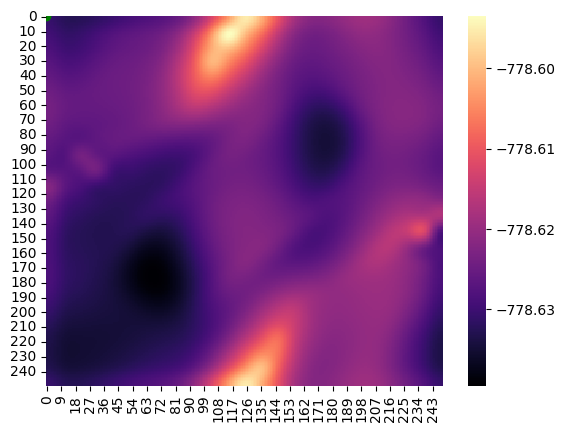

Local Minima:  (80, 19)


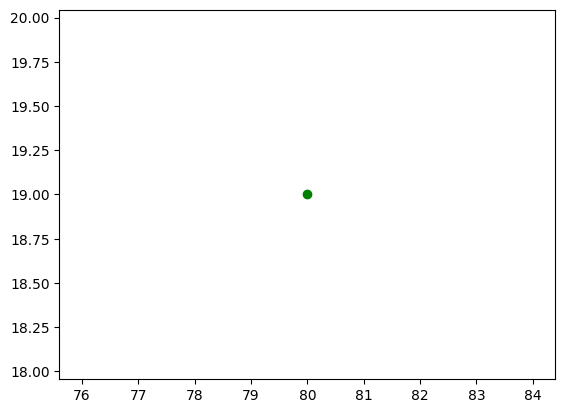

Local Minima:  (85, 175)


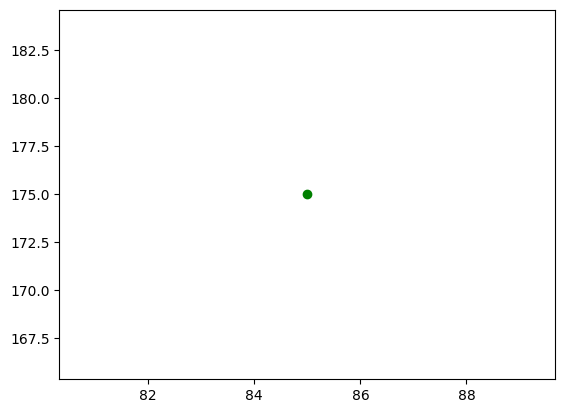

Local Minima:  (96, 8)


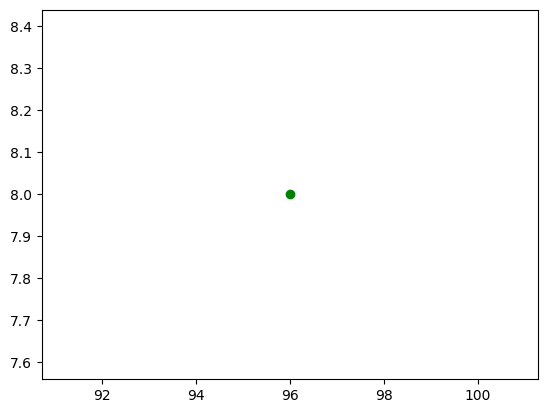

Local Minima:  (146, 36)


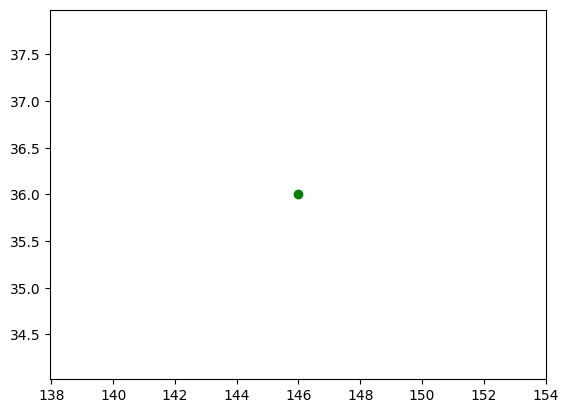

Local Minima:  (149, 169)


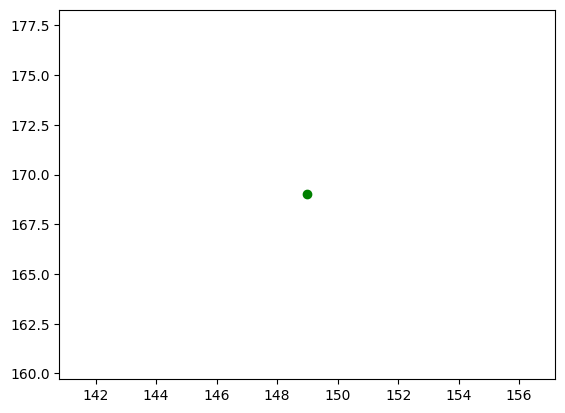

Local Minima:  (150, 249)


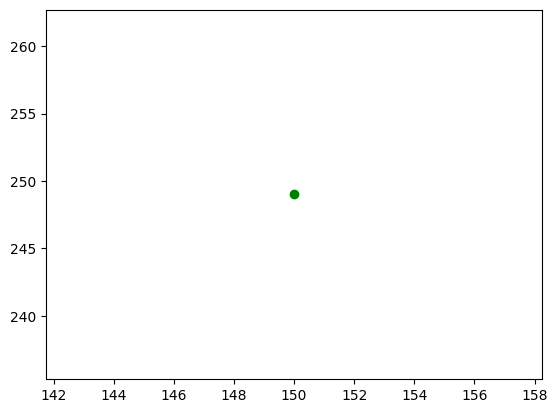

Local Minima:  (169, 249)


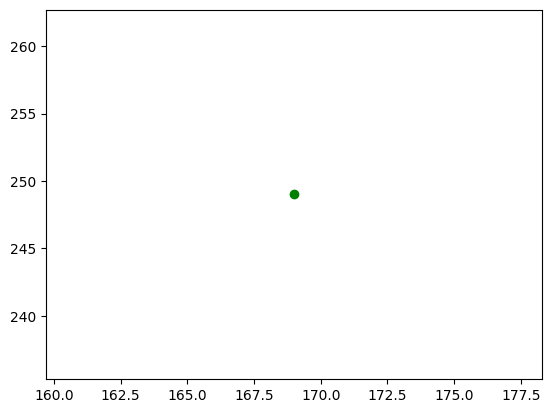

Local Minima:  (176, 67)


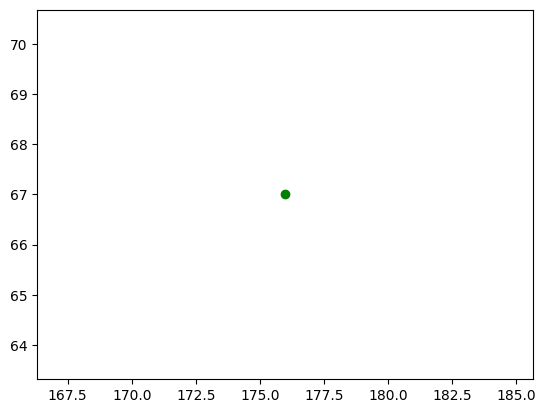

Local Minima:  (225, 16)


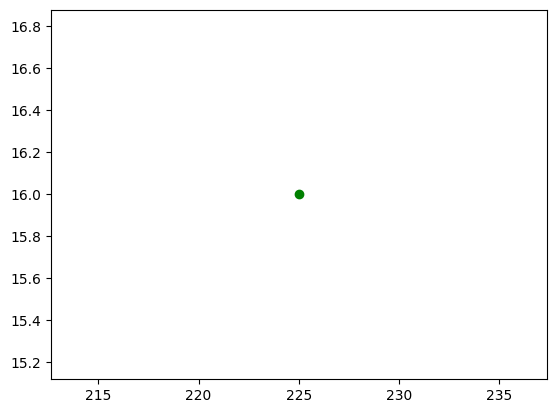

Local Minima:  (237, 174)


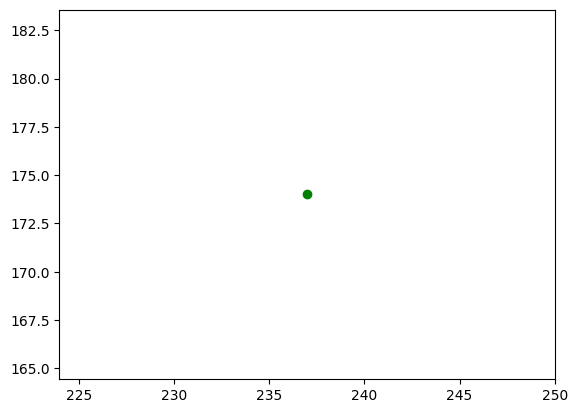

Local Minima:  (0, 29)


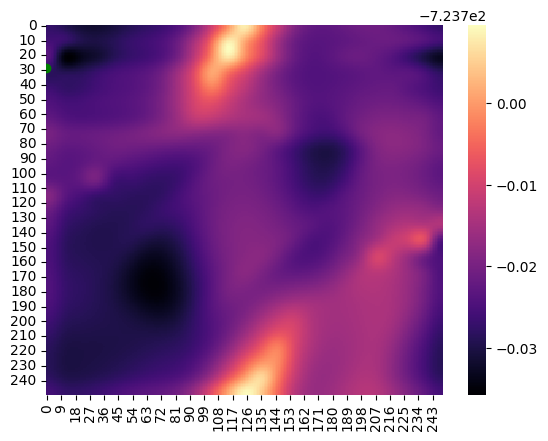

Local Minima:  (0, 249)


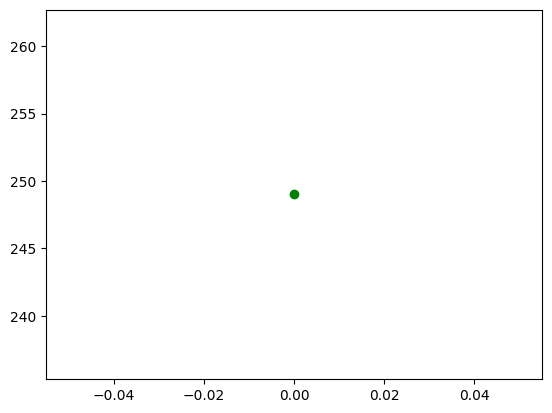

Local Minima:  (21, 14)


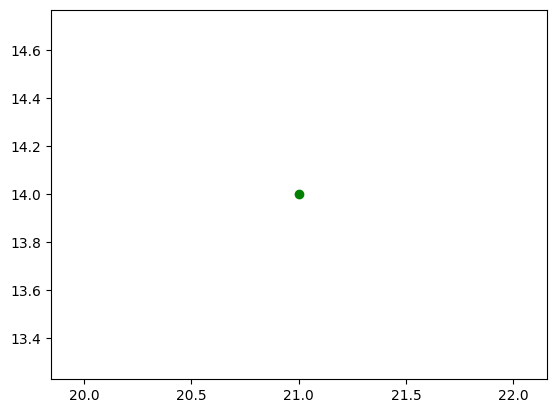

Local Minima:  (22, 249)


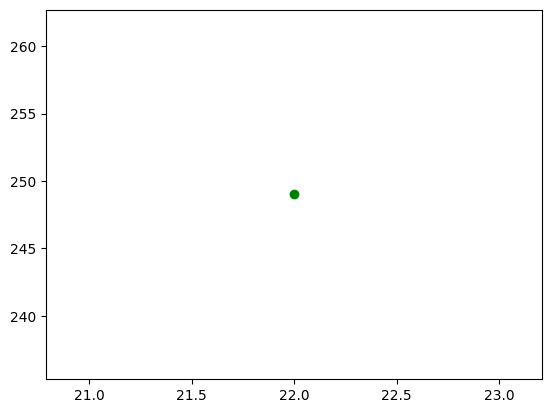

Local Minima:  (34, 170)


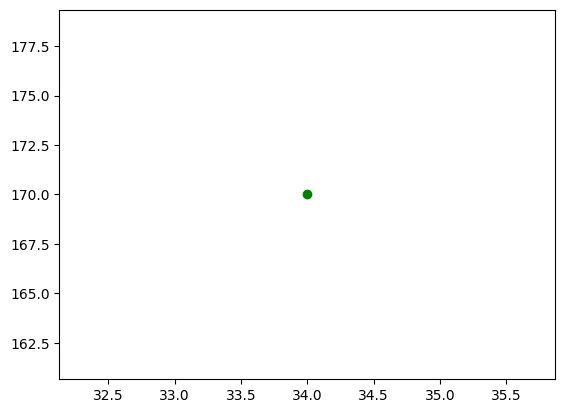

Local Minima:  (87, 175)


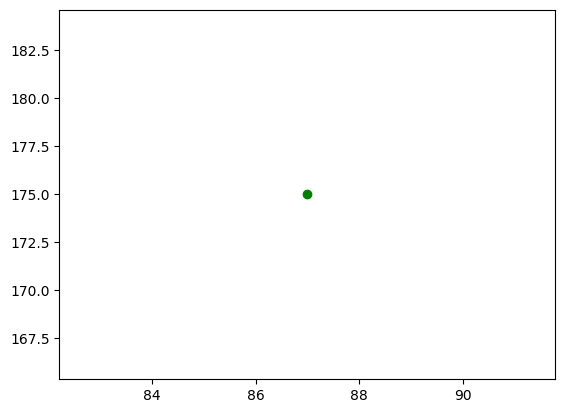

Local Minima:  (95, 12)


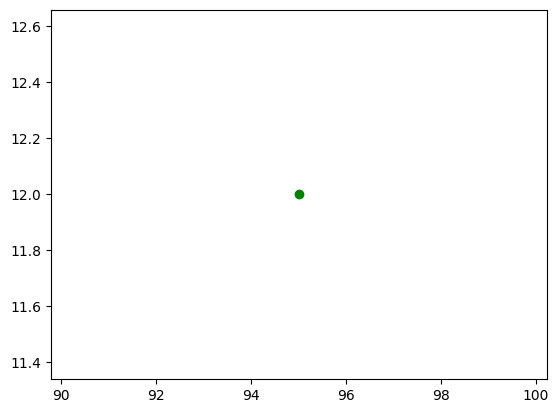

Local Minima:  (143, 35)


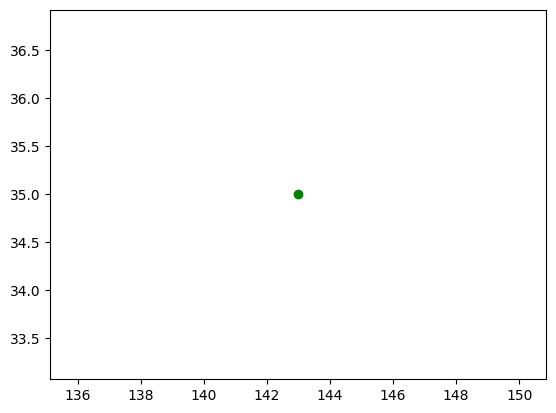

Local Minima:  (149, 169)


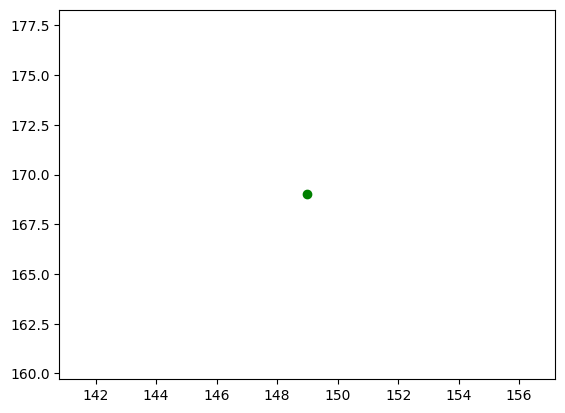

Local Minima:  (150, 249)


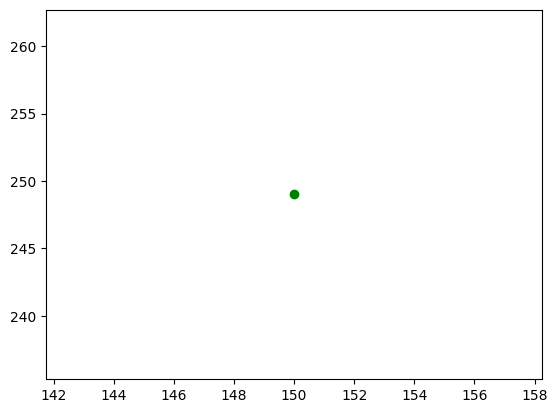

Local Minima:  (174, 67)


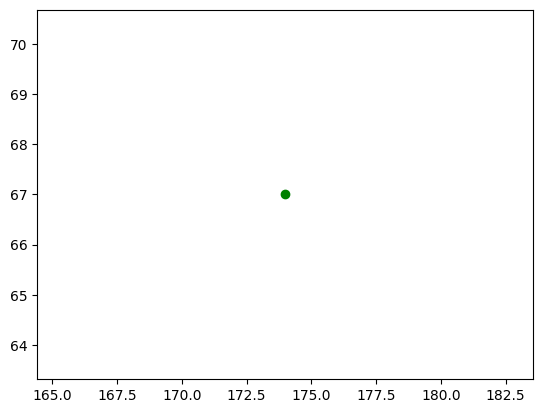

Local Minima:  (225, 16)


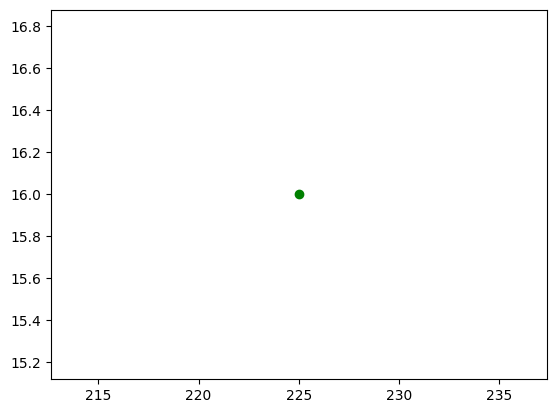

Local Minima:  (238, 174)


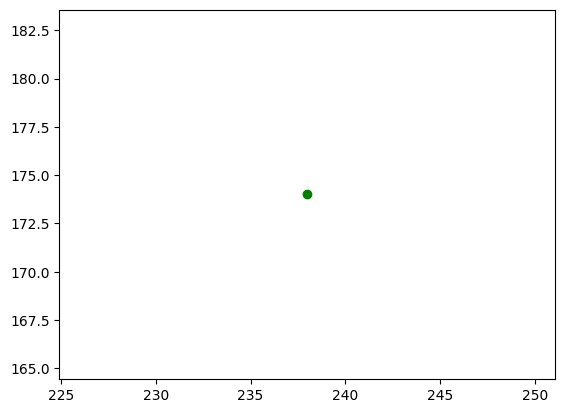

Local Minima:  (0, 13)


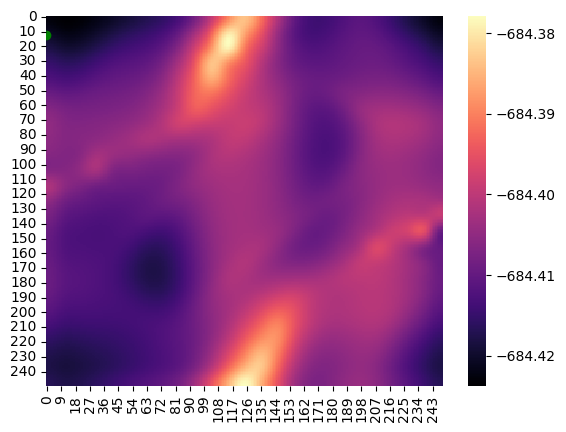

Local Minima:  (0, 171)


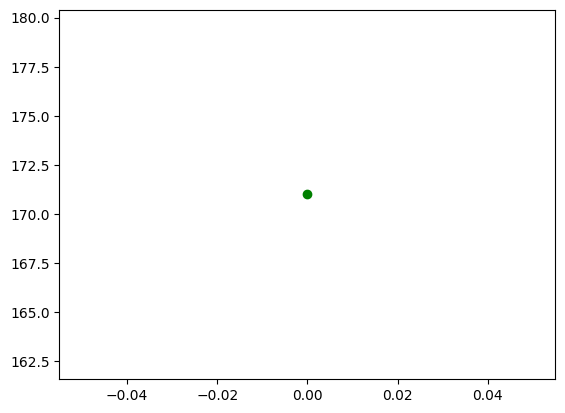

Local Minima:  (0, 249)


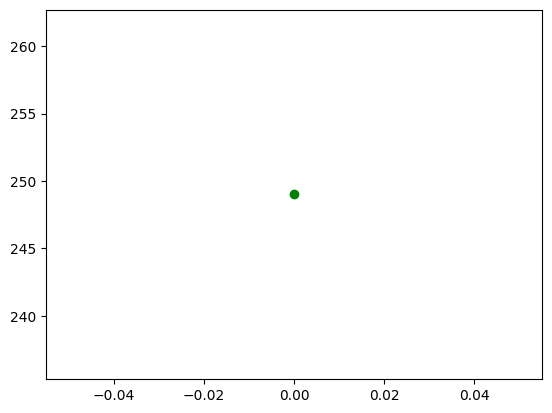

Local Minima:  (88, 175)


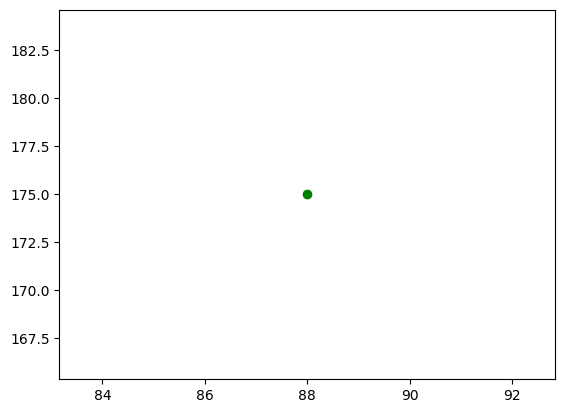

Local Minima:  (100, 0)


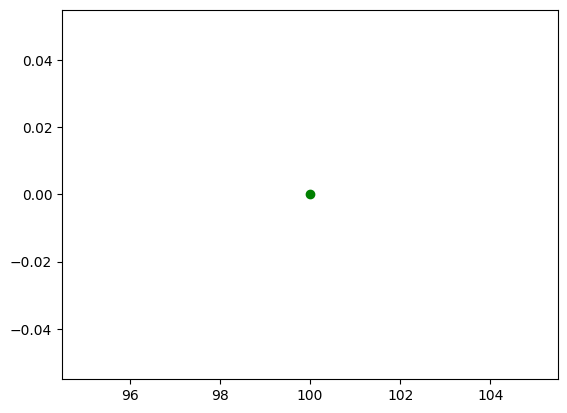

Local Minima:  (147, 170)


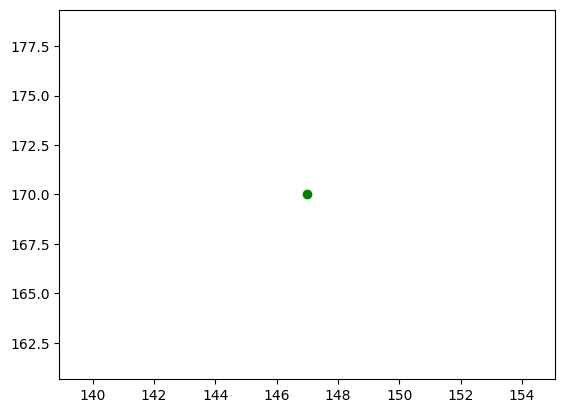

Local Minima:  (148, 32)


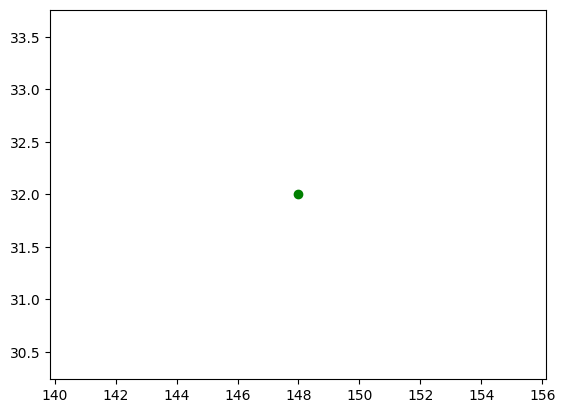

Local Minima:  (150, 249)


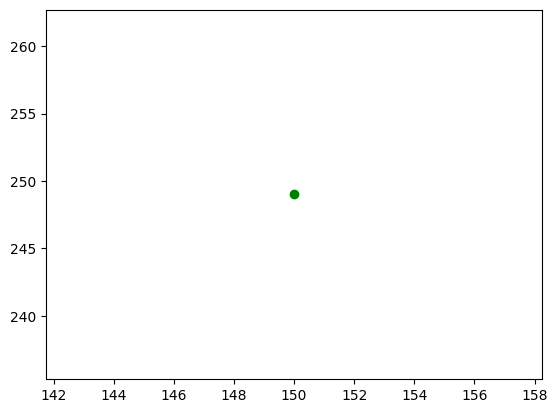

Local Minima:  (172, 67)


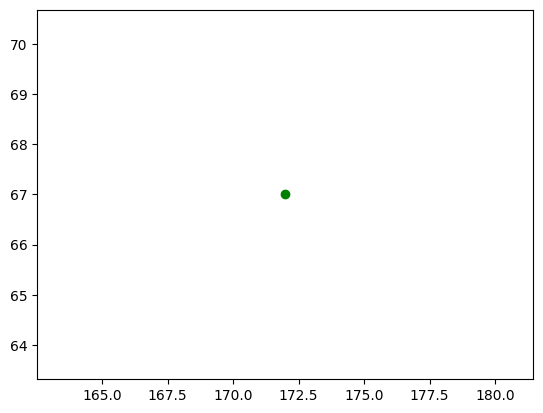

Local Minima:  (236, 12)


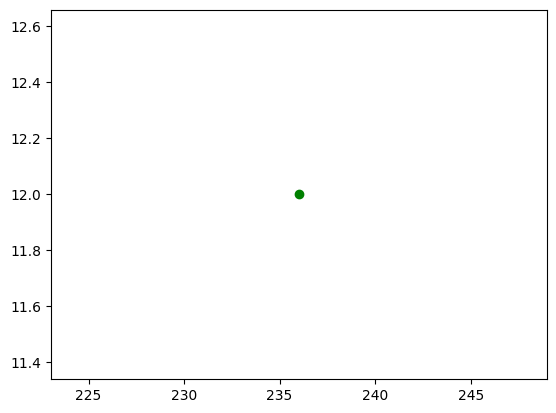

Local Minima:  (236, 249)


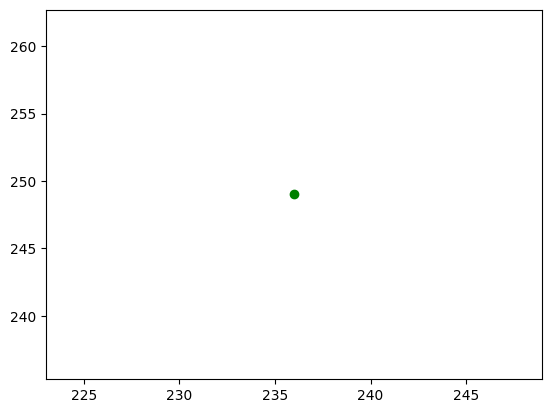

Local Minima:  (3, 249)


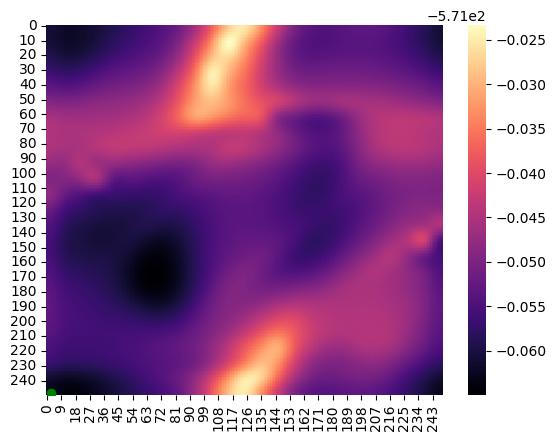

Local Minima:  (5, 15)


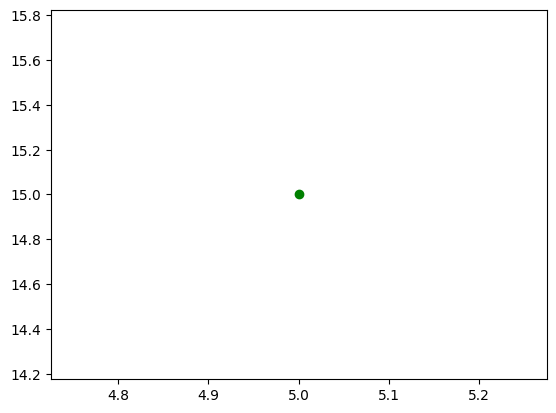

Local Minima:  (10, 172)


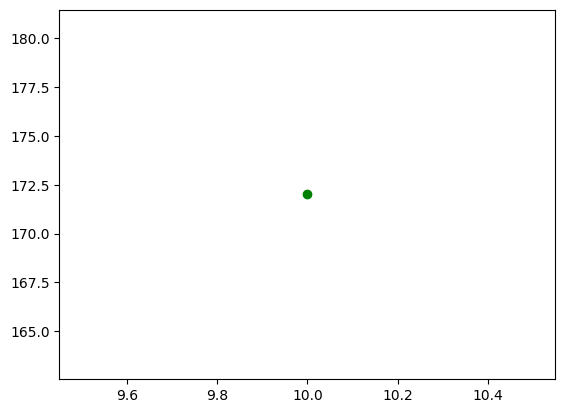

Local Minima:  (67, 171)


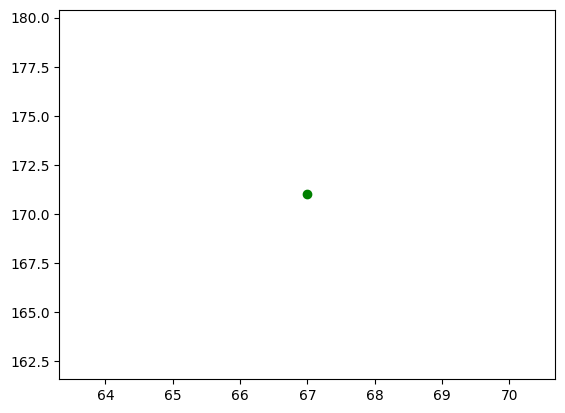

Local Minima:  (110, 170)


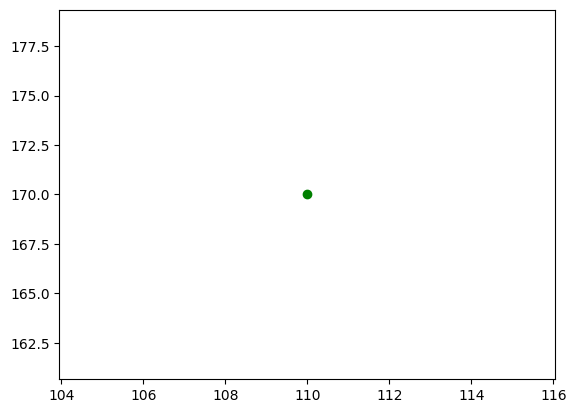

Local Minima:  (110, 249)


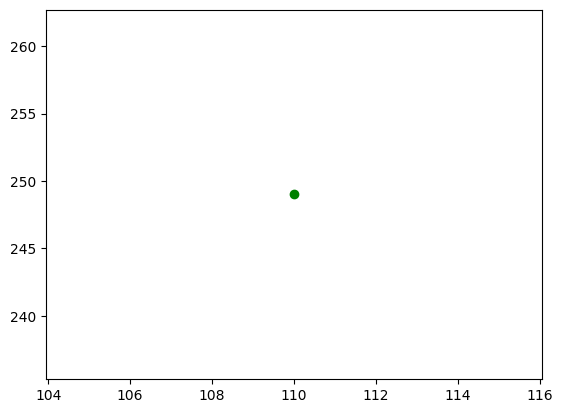

Local Minima:  (141, 36)


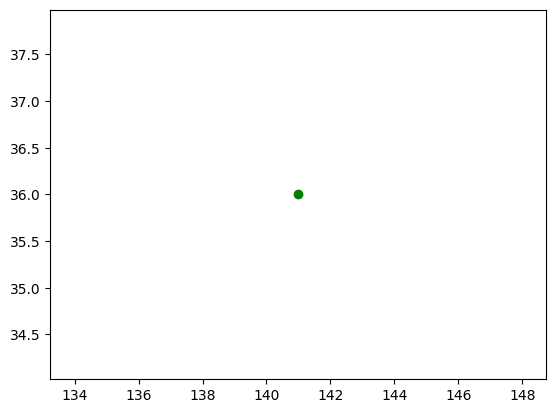

Local Minima:  (146, 169)


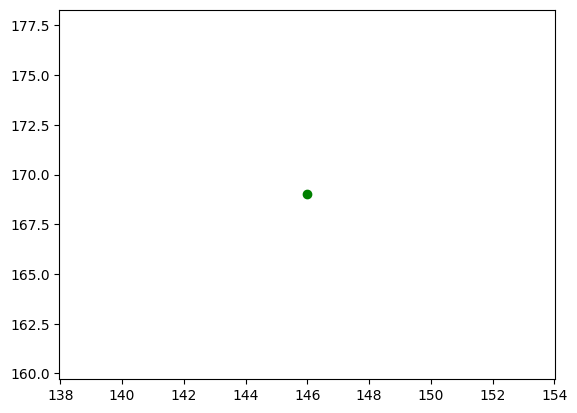

Local Minima:  (151, 249)


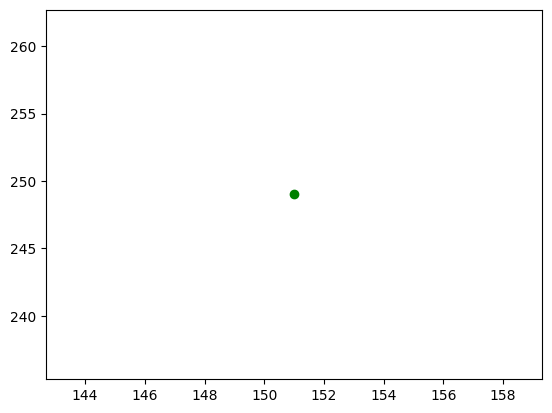

Local Minima:  (168, 67)


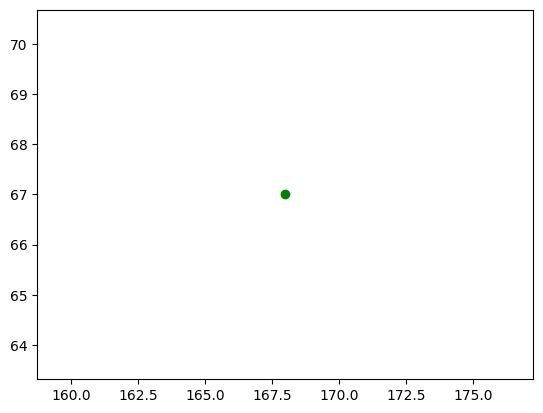

Local Minima:  (249, 15)


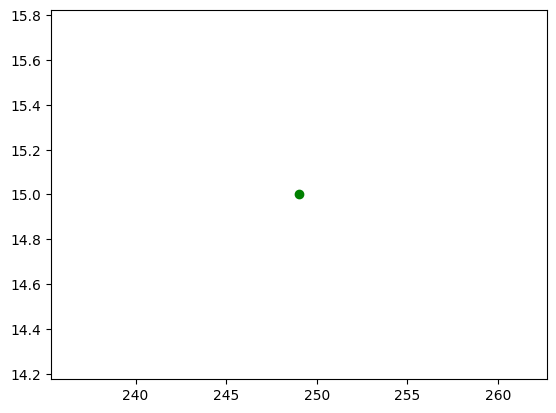

Local Minima:  (249, 249)


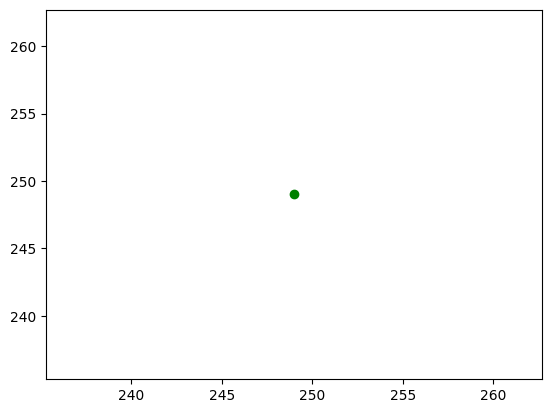

Local Minima:  (0, 17)


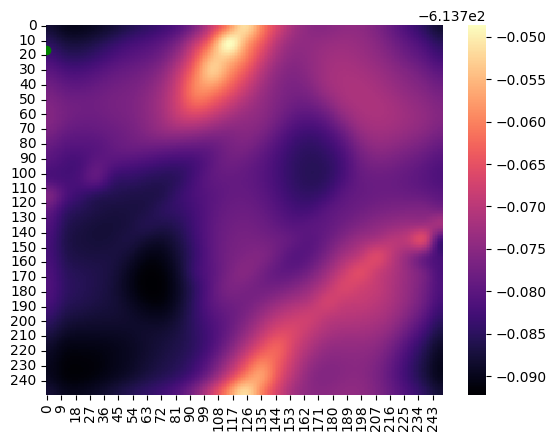

Local Minima:  (98, 14)


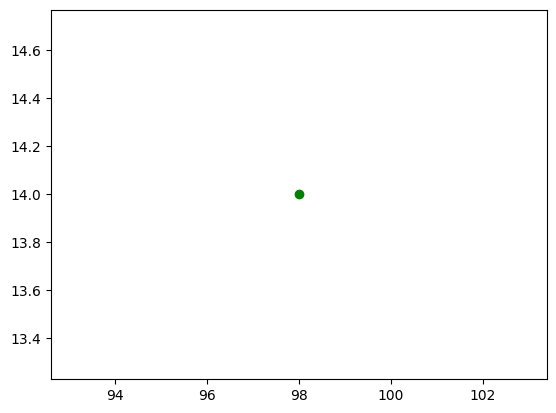

Local Minima:  (99, 167)


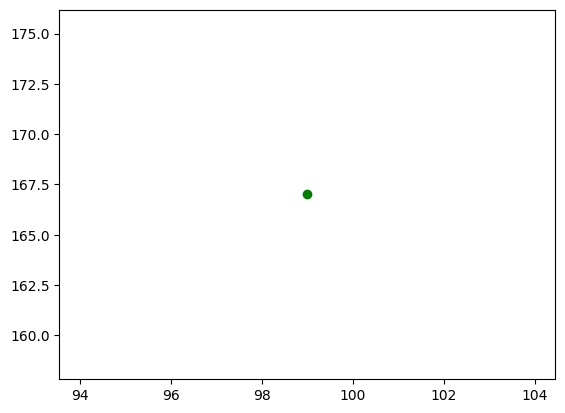

Local Minima:  (139, 35)


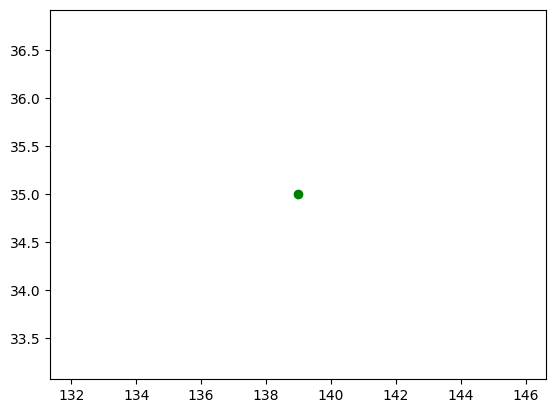

Local Minima:  (149, 249)


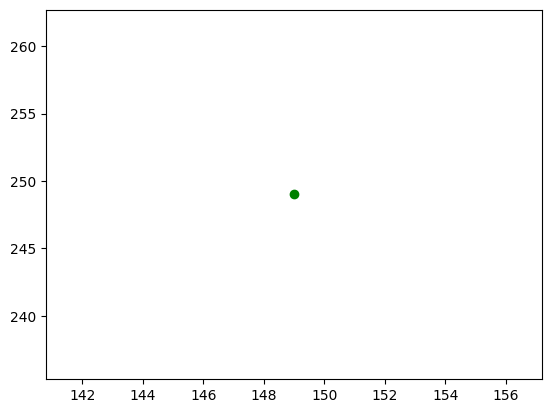

Local Minima:  (156, 158)


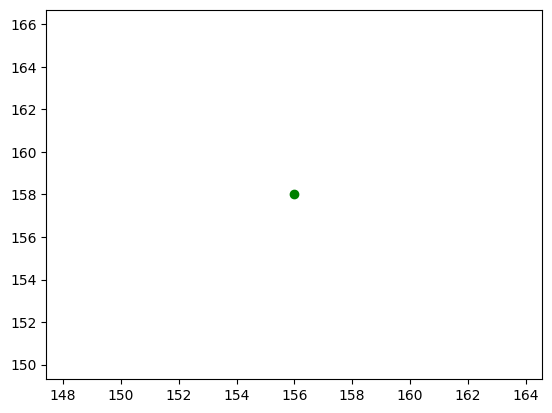

Local Minima:  (174, 66)


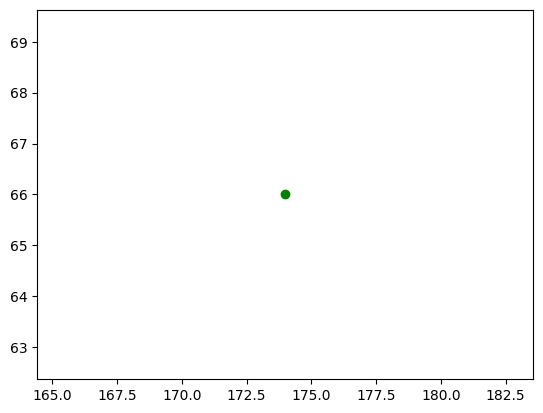

Local Minima:  (232, 249)


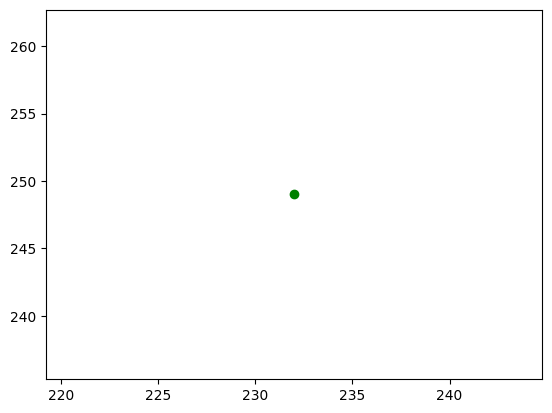

Local Minima:  (233, 18)


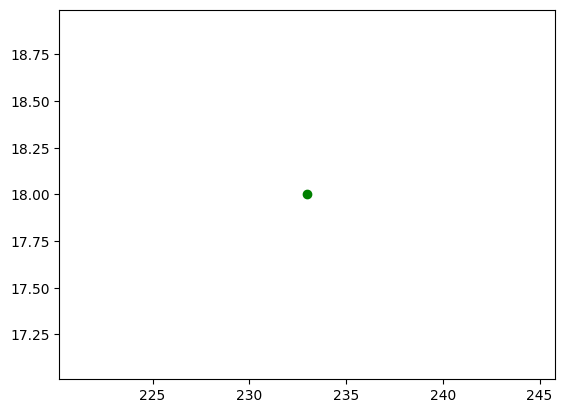

Local Minima:  (237, 176)


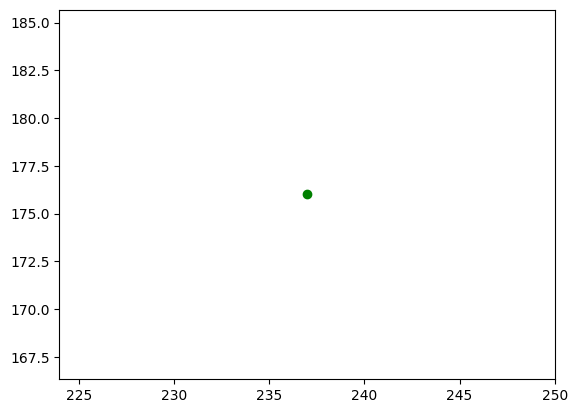

Local Minima:  (0, 249)


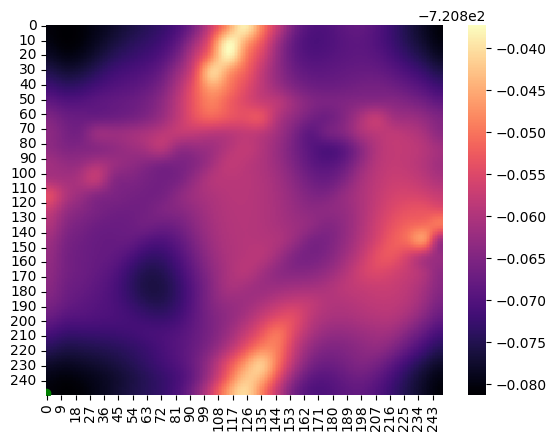

Local Minima:  (2, 12)


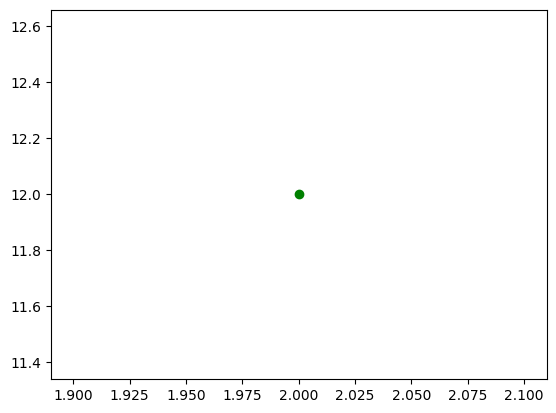

Local Minima:  (10, 170)


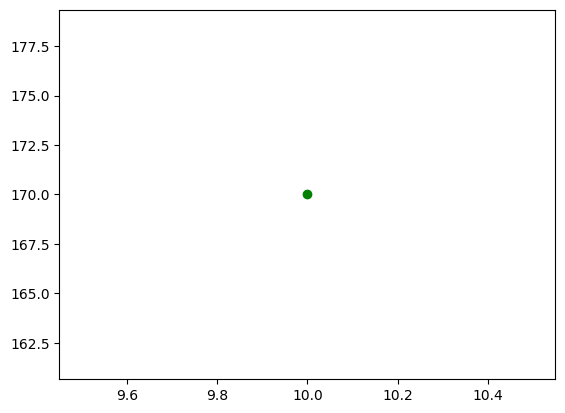

Local Minima:  (86, 177)


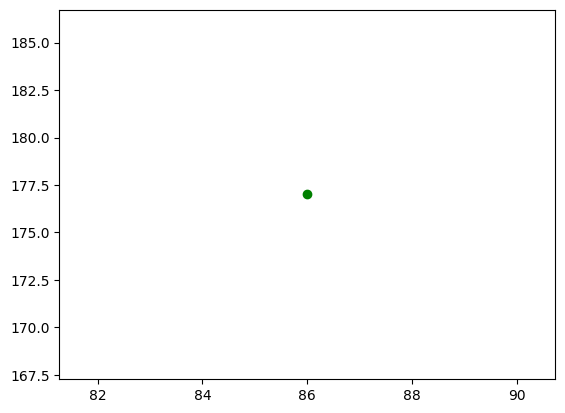

Local Minima:  (100, 74)


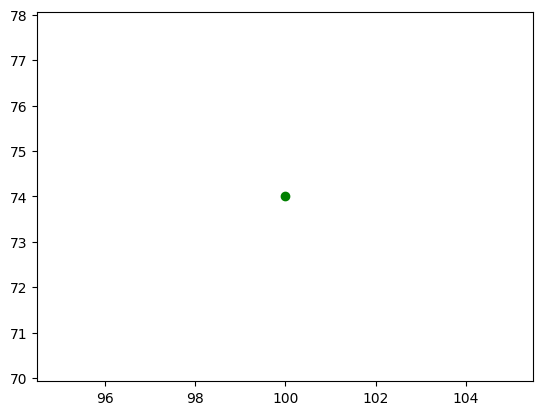

Local Minima:  (111, 68)


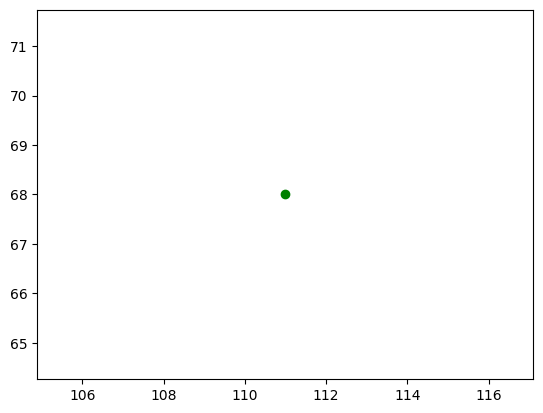

Local Minima:  (150, 249)


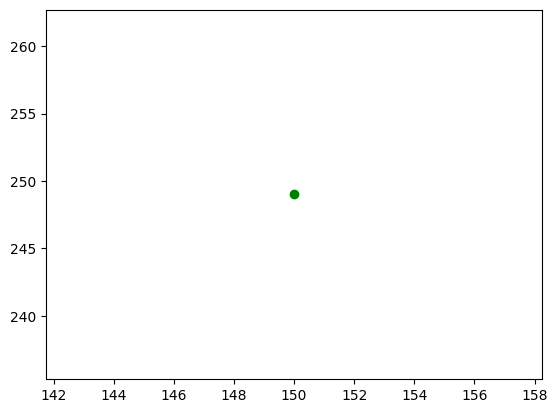

Local Minima:  (151, 169)


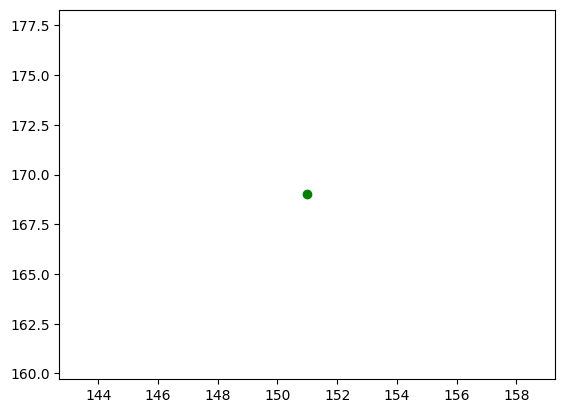

Local Minima:  (176, 67)


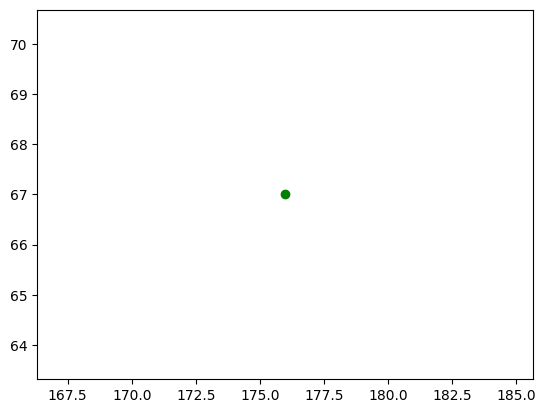

Local Minima:  (249, 12)


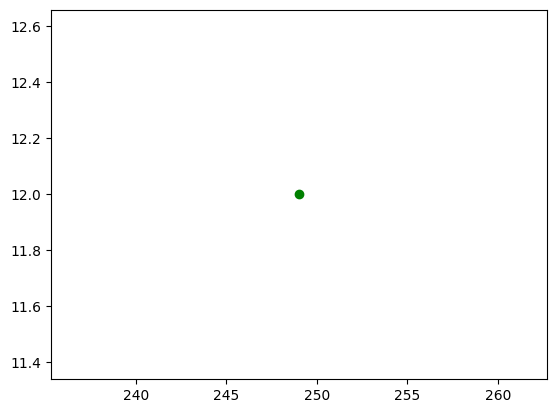

Local Minima:  (249, 172)


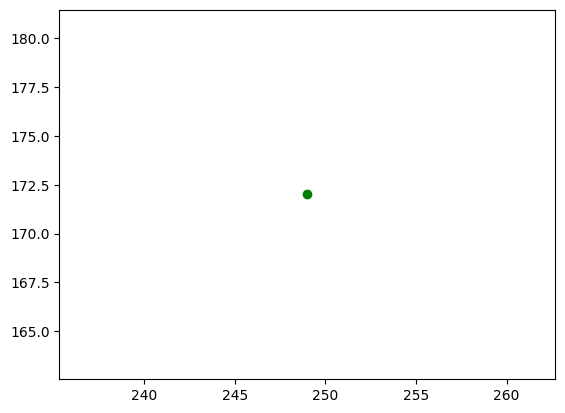

Local Minima:  (249, 16)


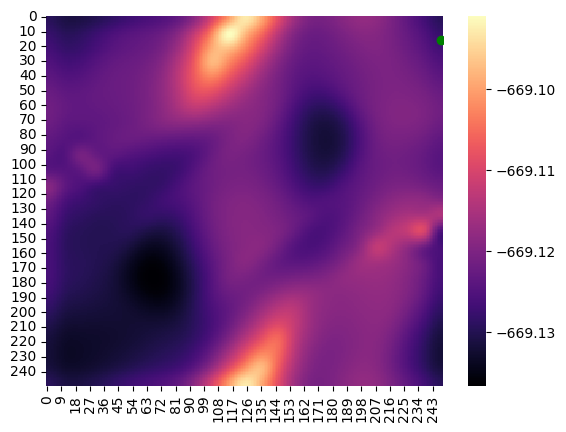

Local Minima:  (0, 0)


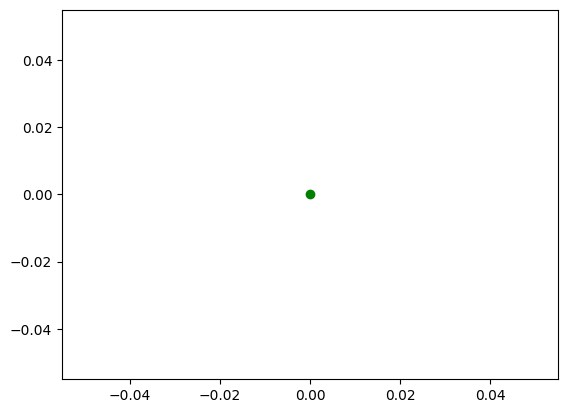

Local Minima:  (80, 19)


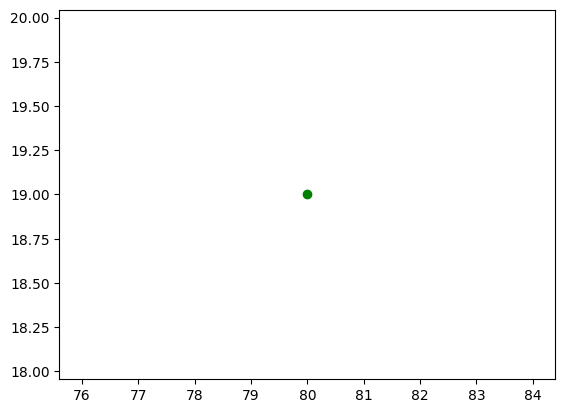

Local Minima:  (83, 176)


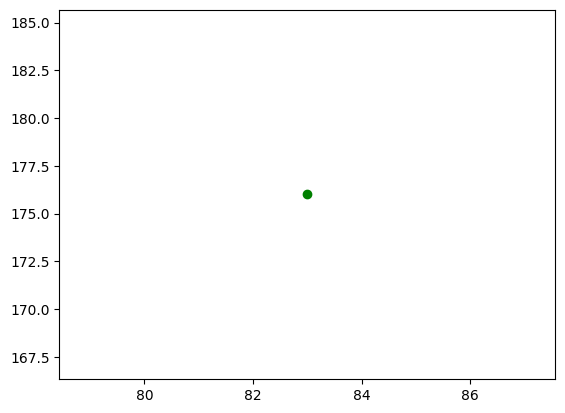

Local Minima:  (96, 8)


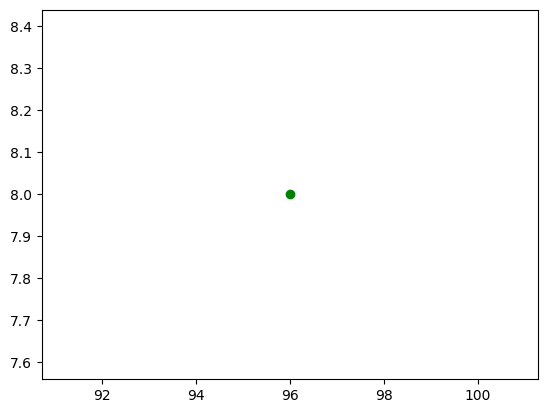

Local Minima:  (149, 169)


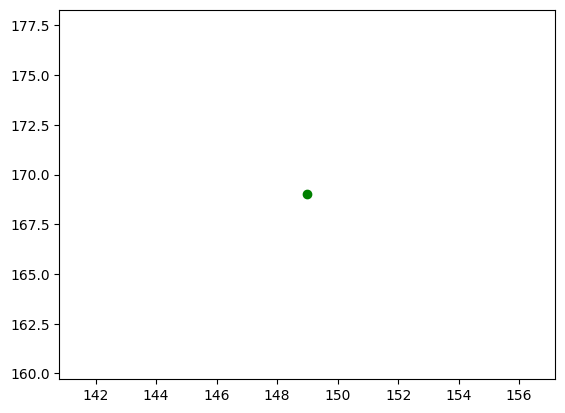

Local Minima:  (150, 249)


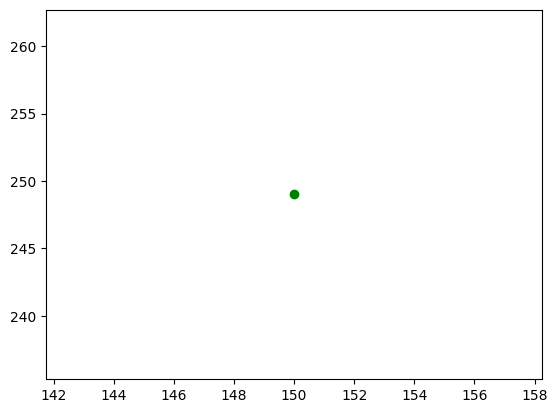

Local Minima:  (171, 249)


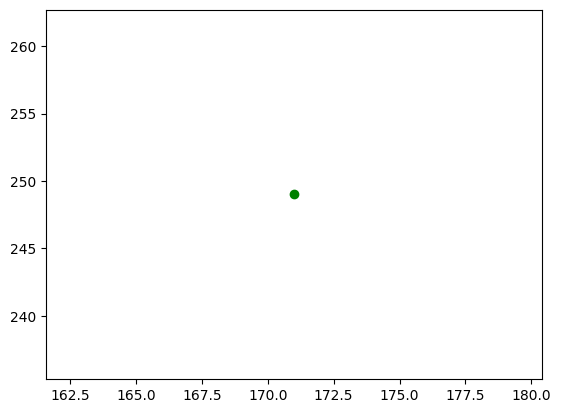

Local Minima:  (176, 67)


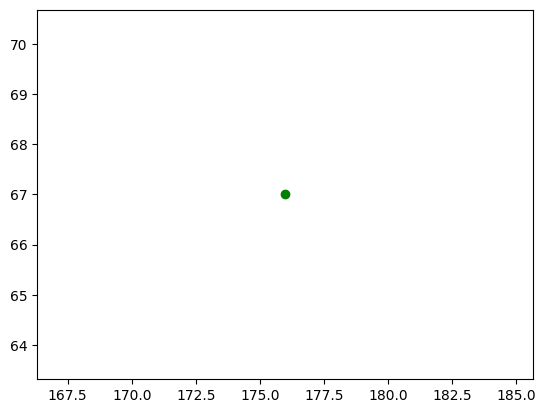

Local Minima:  (227, 15)


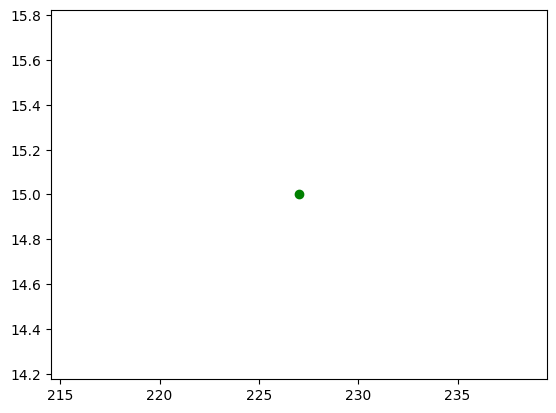

Local Minima:  (0, 15)


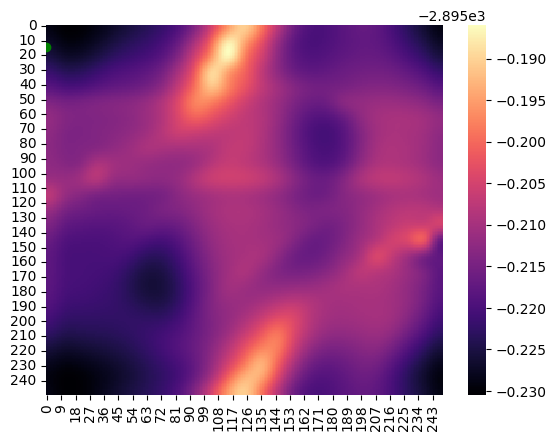

Local Minima:  (9, 169)


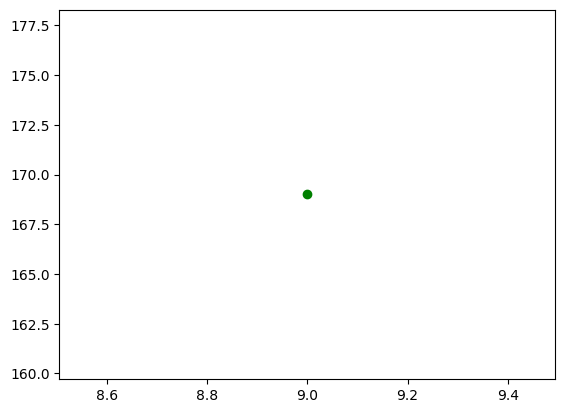

Local Minima:  (73, 17)


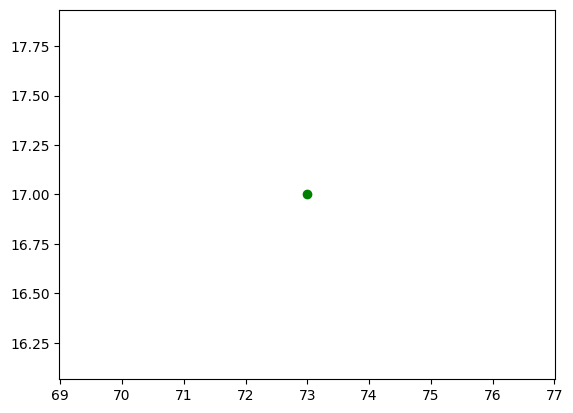

Local Minima:  (74, 174)


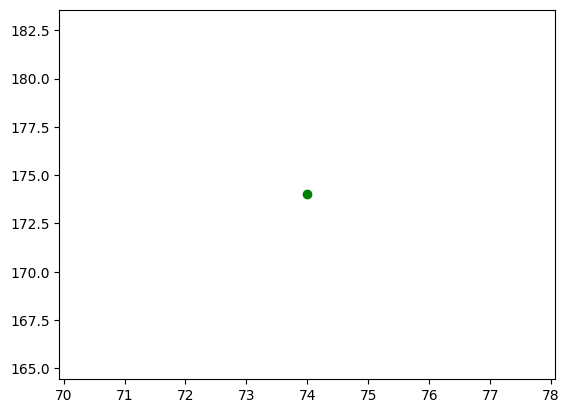

Local Minima:  (85, 249)


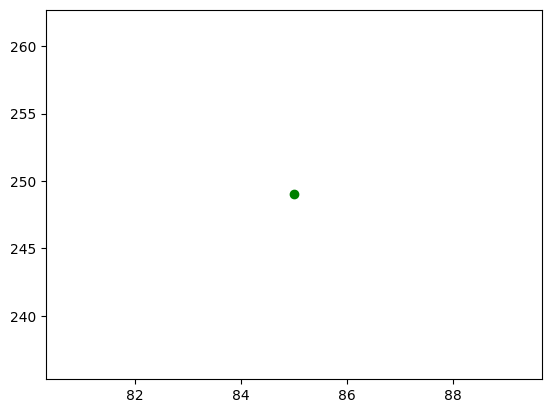

Local Minima:  (150, 168)


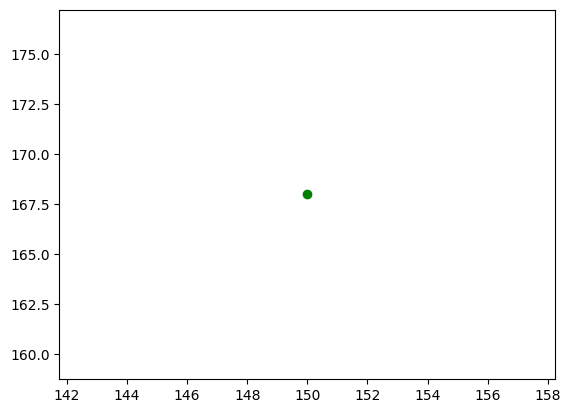

Local Minima:  (150, 249)


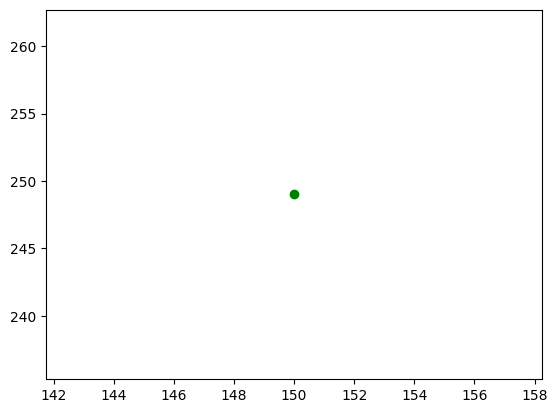

Local Minima:  (175, 67)


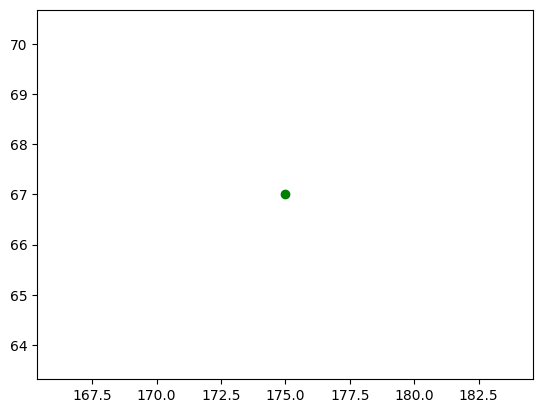

Local Minima:  (243, 14)


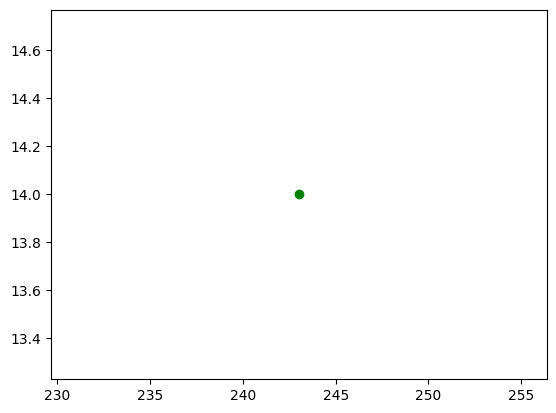

Local Minima:  (249, 171)


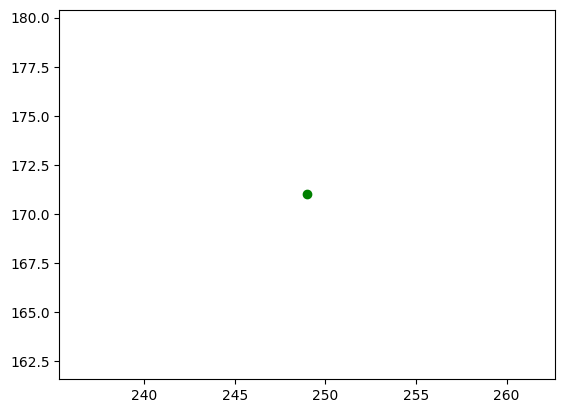

Local Minima:  (11, 169)


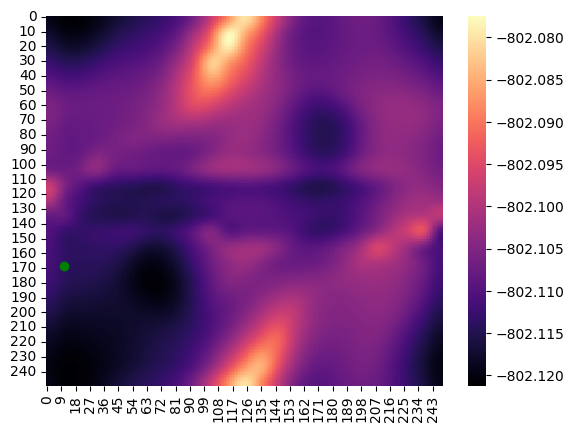

Local Minima:  (78, 175)


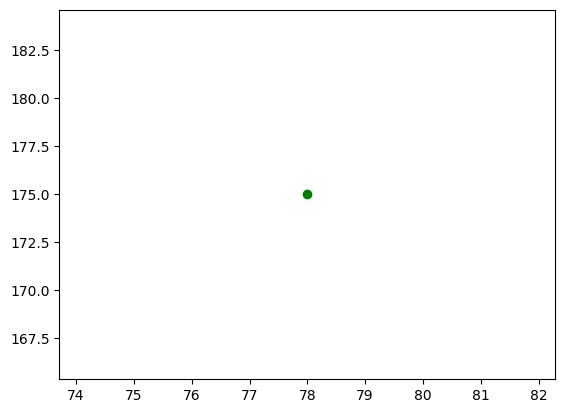

Local Minima:  (88, 16)


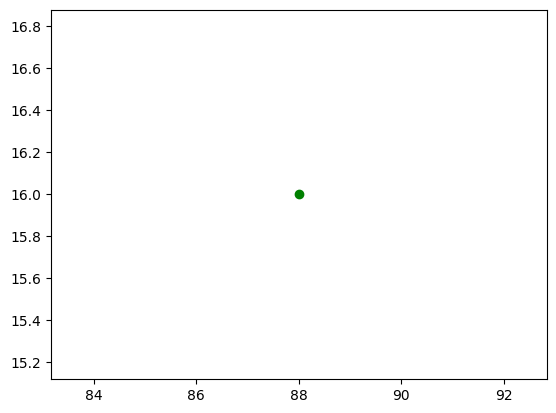

Local Minima:  (92, 249)


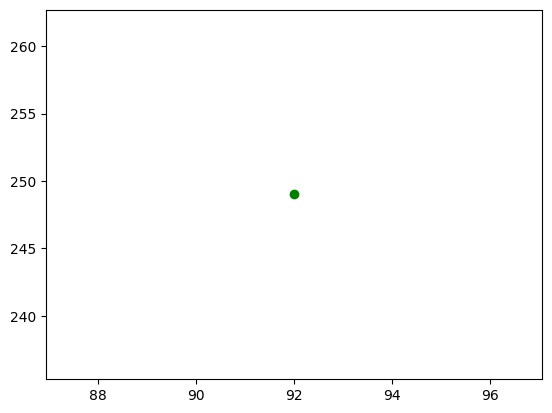

Local Minima:  (94, 79)


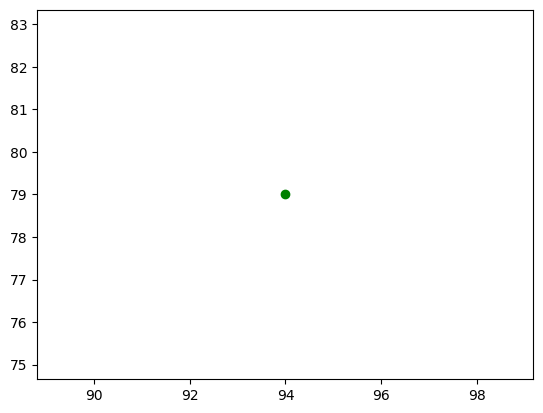

Local Minima:  (116, 171)


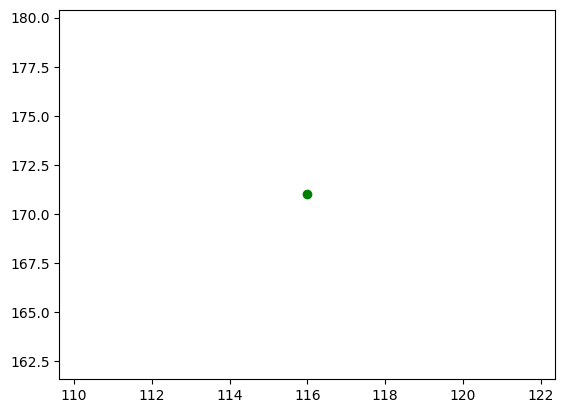

Local Minima:  (118, 63)


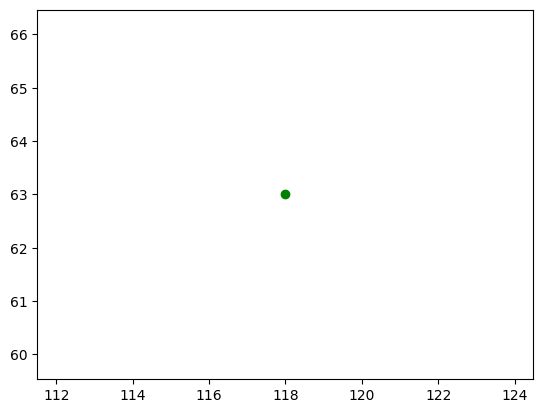

Local Minima:  (132, 45)


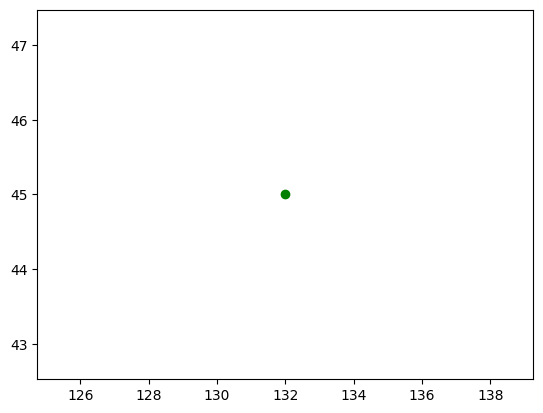

Local Minima:  (134, 75)


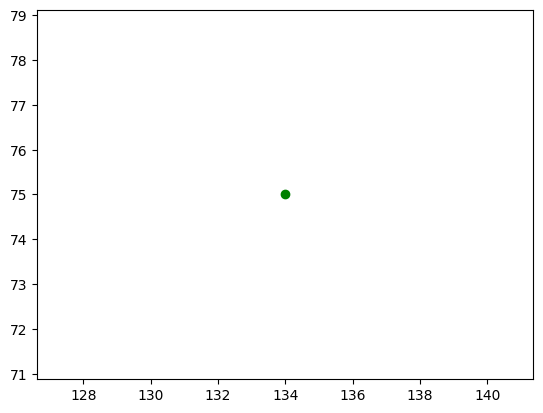

Local Minima:  (141, 116)


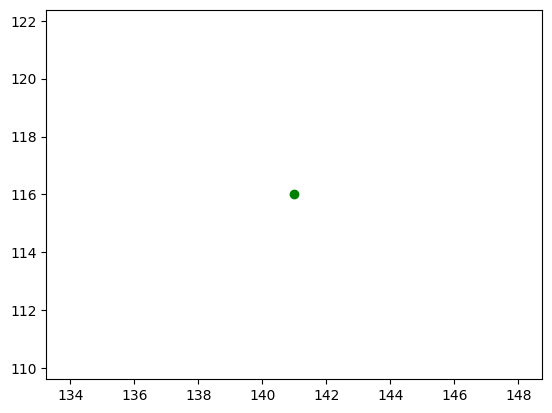

Local Minima:  (141, 175)


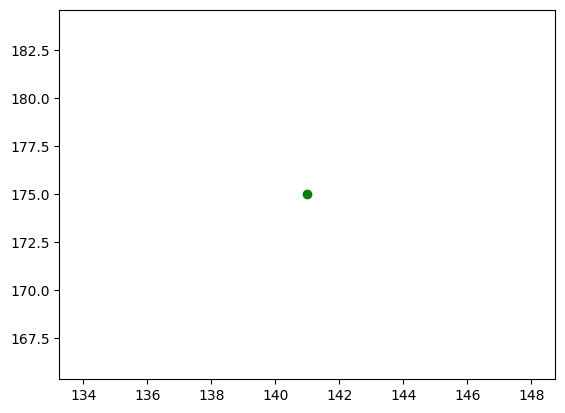

Local Minima:  (150, 249)


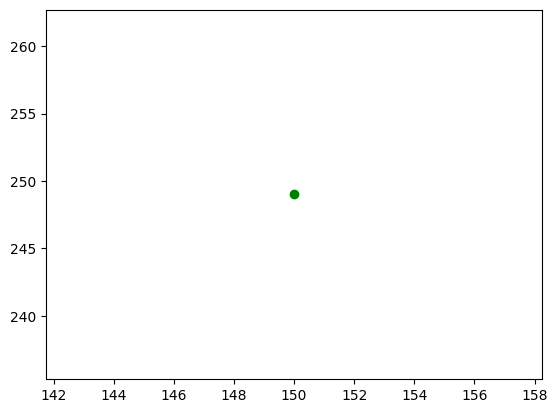

Local Minima:  (179, 67)


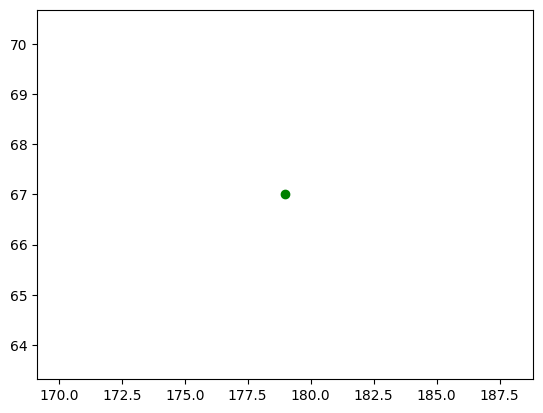

Local Minima:  (238, 249)


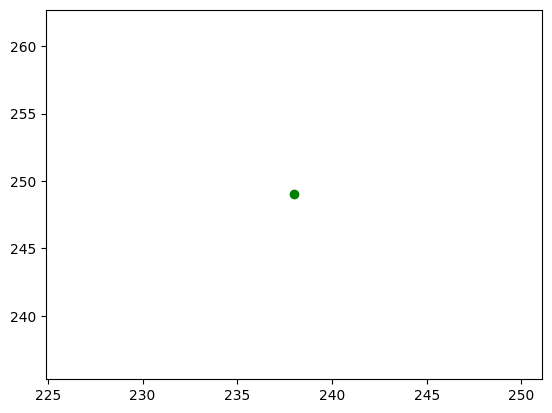

Local Minima:  (240, 14)


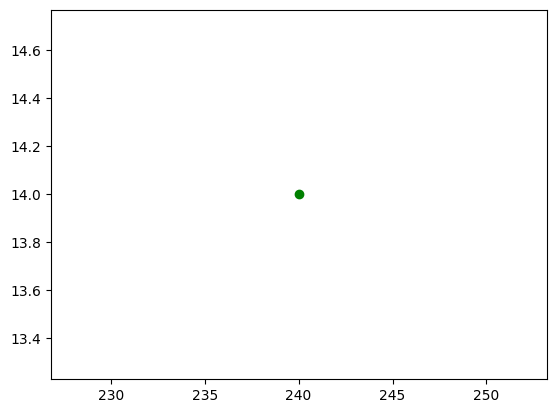

Local Minima:  (249, 171)


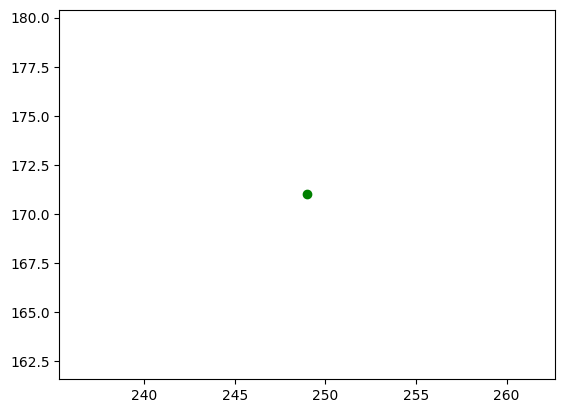

Local Minima:  (249, 172)


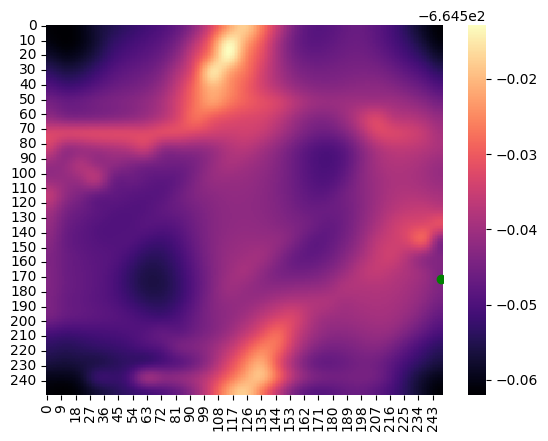

Local Minima:  (4, 11)


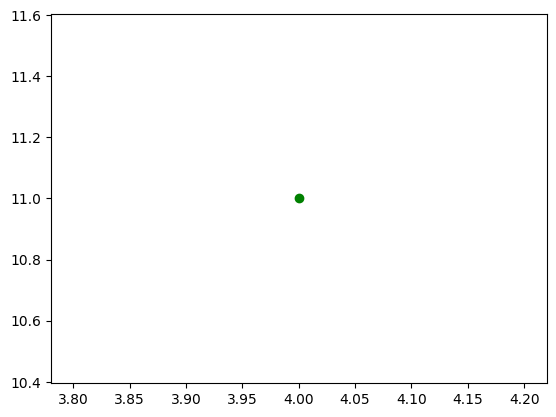

Local Minima:  (88, 12)


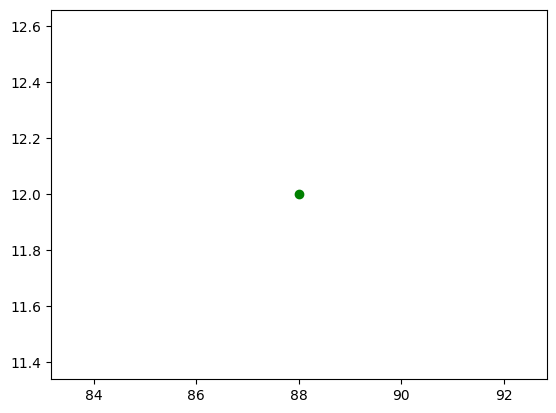

Local Minima:  (90, 176)


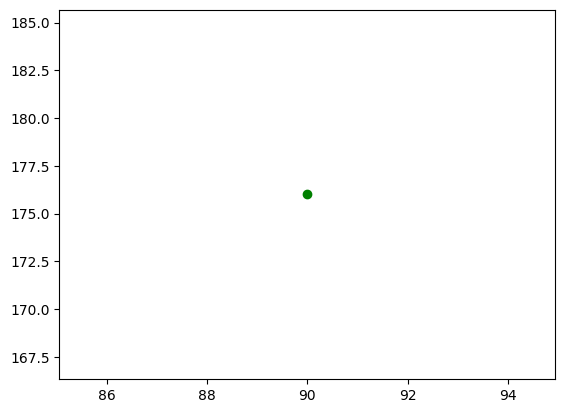

Local Minima:  (99, 0)


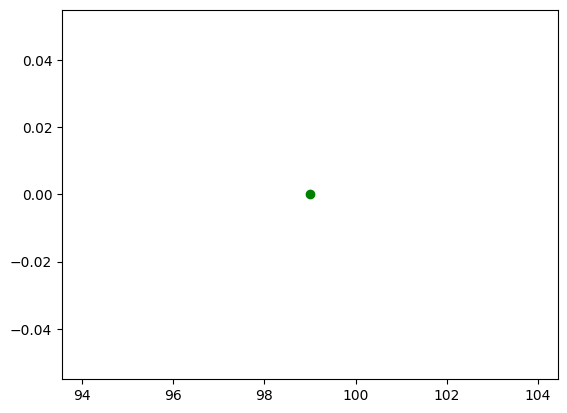

Local Minima:  (133, 47)


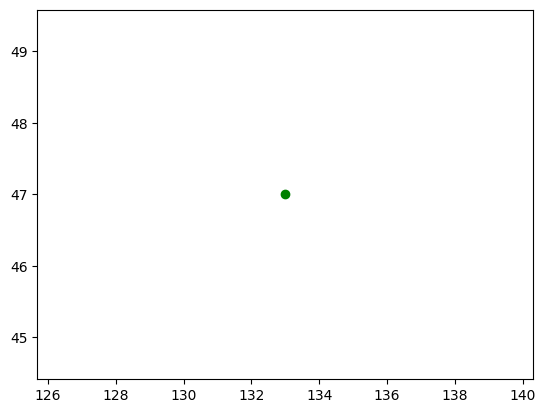

Local Minima:  (148, 170)


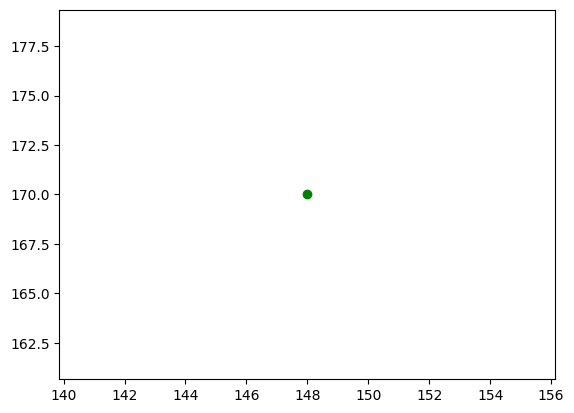

Local Minima:  (150, 249)


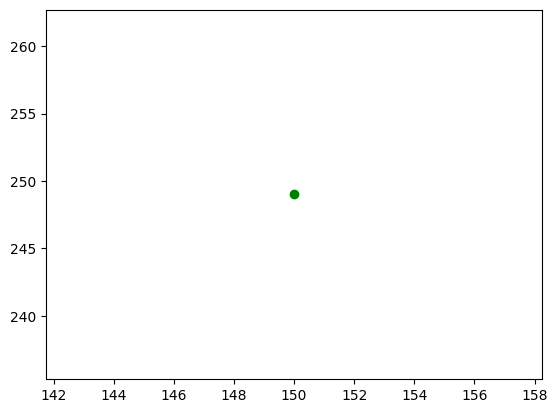

Local Minima:  (168, 249)


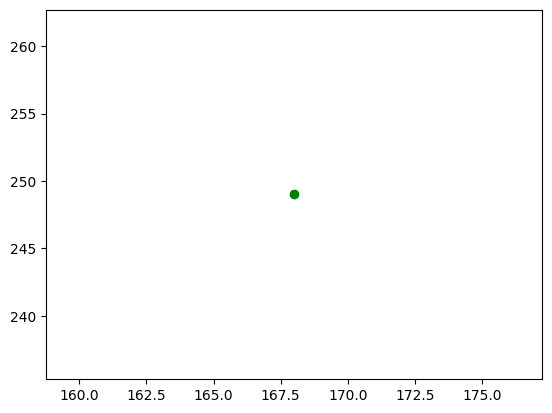

Local Minima:  (173, 67)


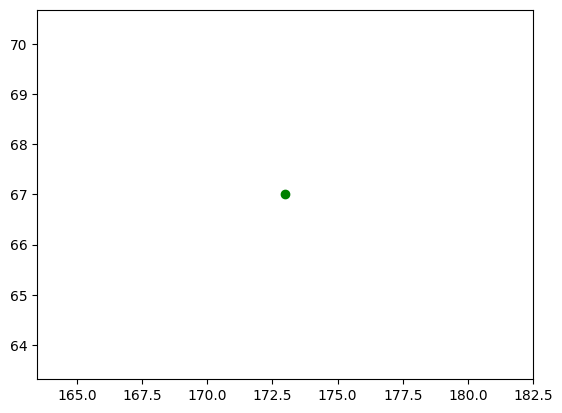

Local Minima:  (228, 177)


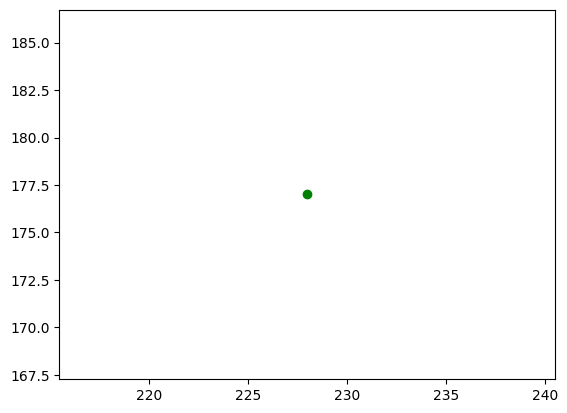

Local Minima:  (249, 10)


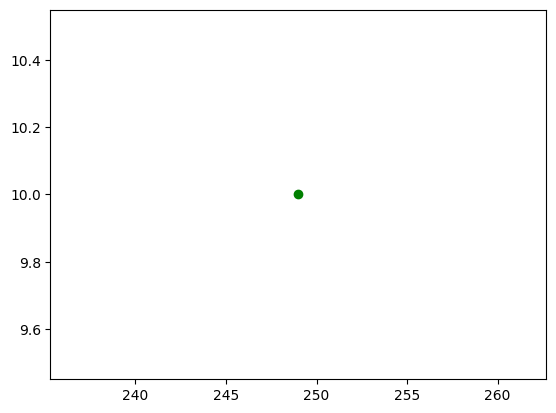

Local Minima:  (249, 0)


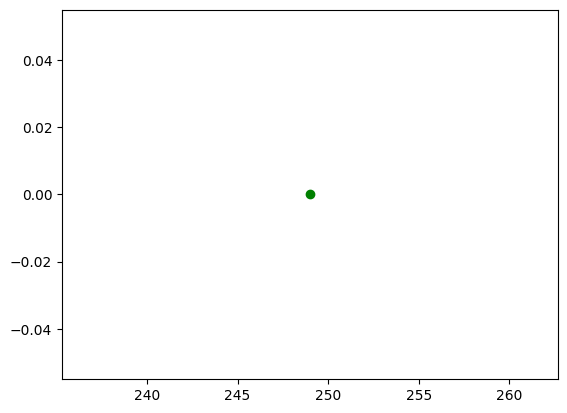

Local Minima:  (0, 48)


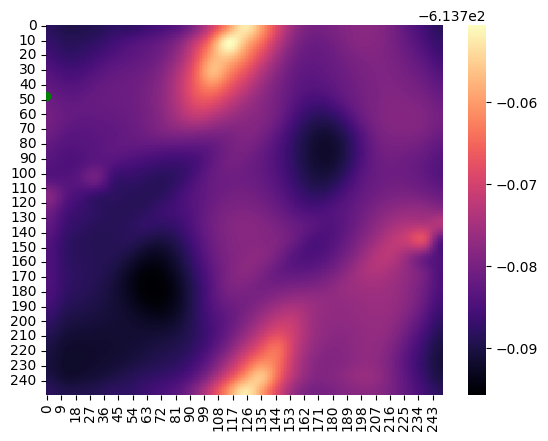

Local Minima:  (0, 0)


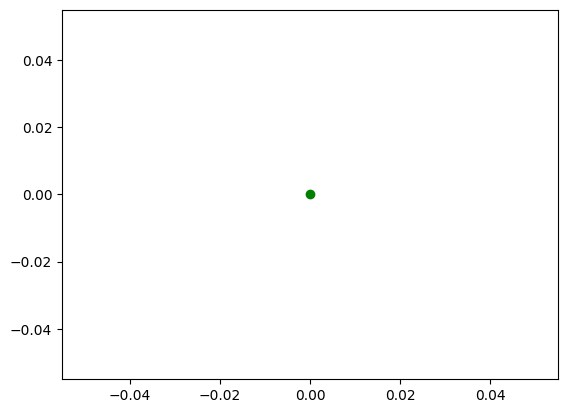

Local Minima:  (85, 175)


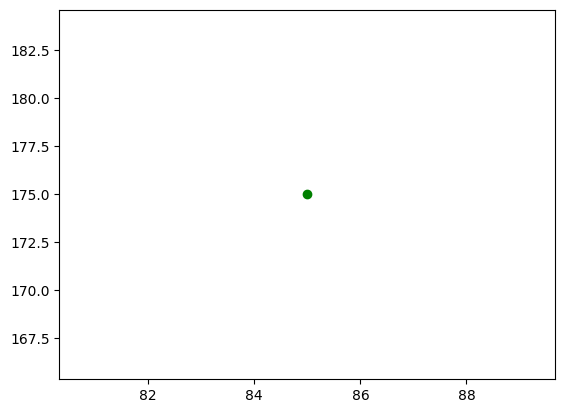

Local Minima:  (93, 13)


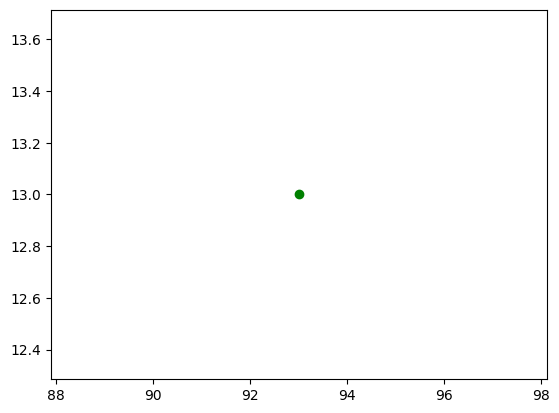

Local Minima:  (111, 66)


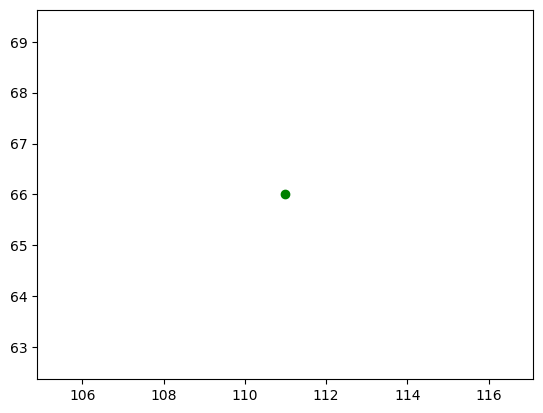

Local Minima:  (119, 56)


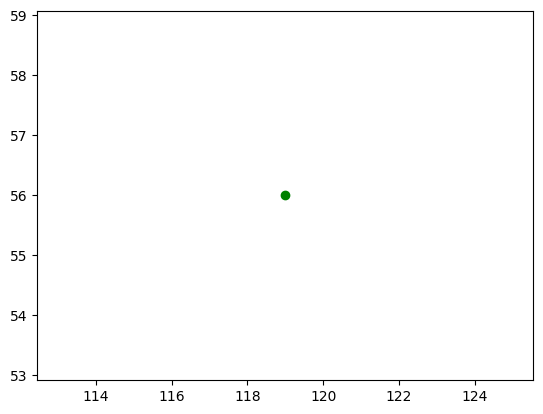

Local Minima:  (128, 45)


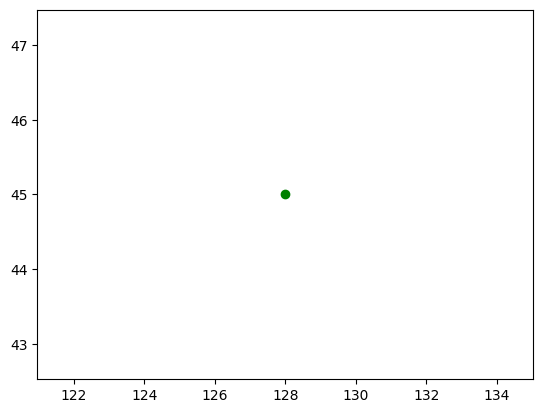

Local Minima:  (147, 35)


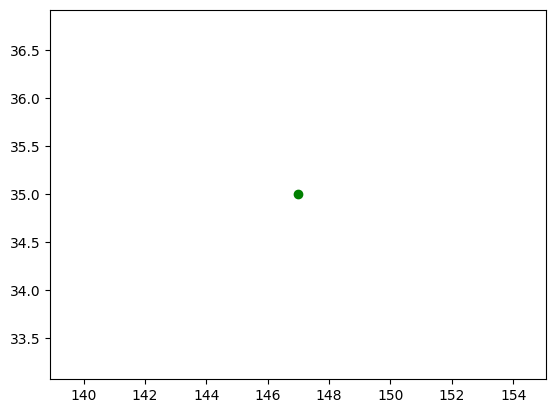

Local Minima:  (149, 169)


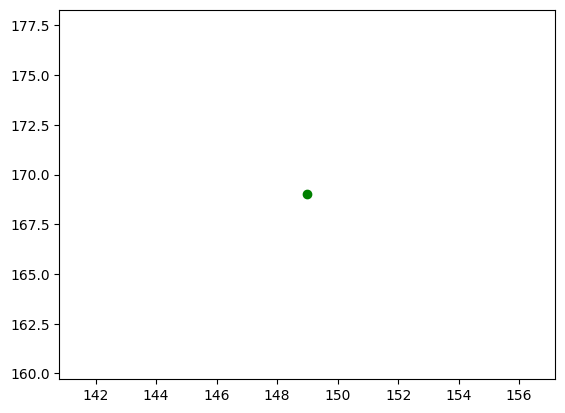

Local Minima:  (151, 249)


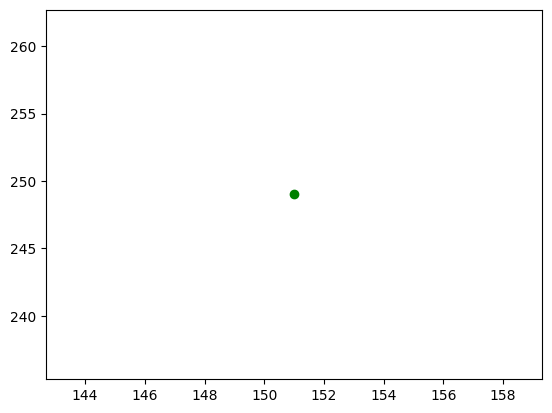

Local Minima:  (176, 67)


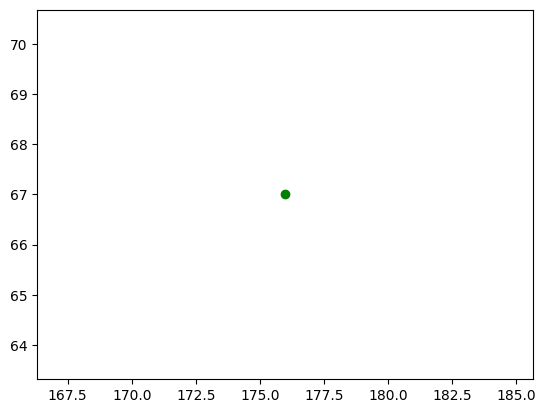

Local Minima:  (227, 249)


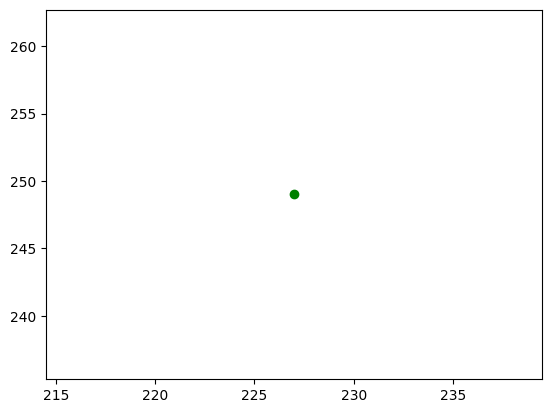

Local Minima:  (228, 16)


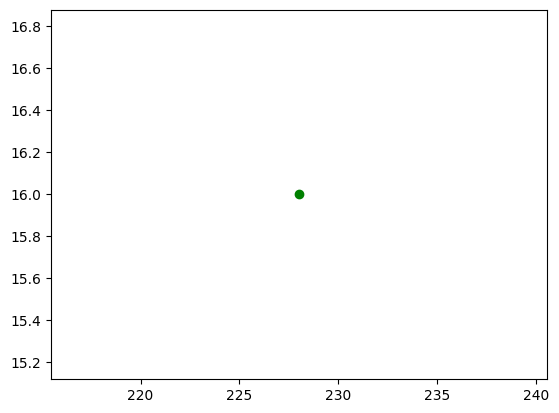

Local Minima:  (228, 178)


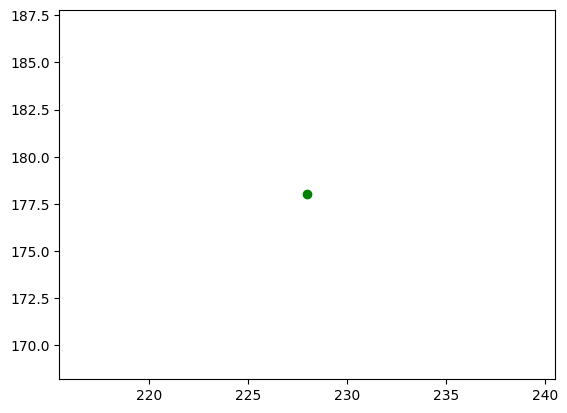

Local Minima:  (249, 171)


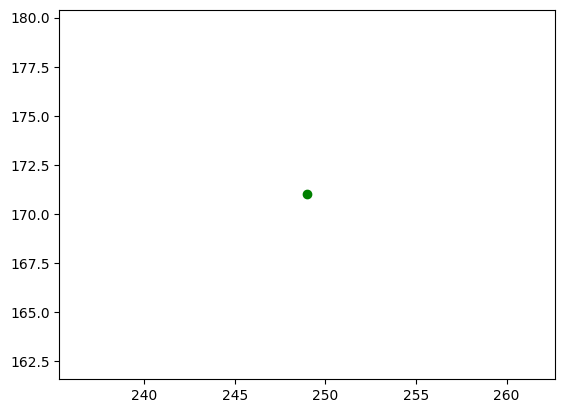

Local Minima:  (10, 167)


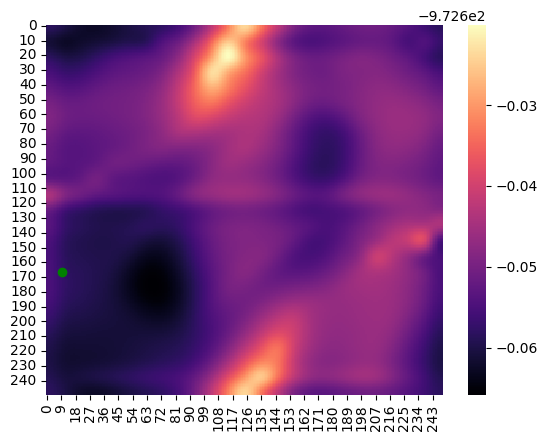

Local Minima:  (10, 229)


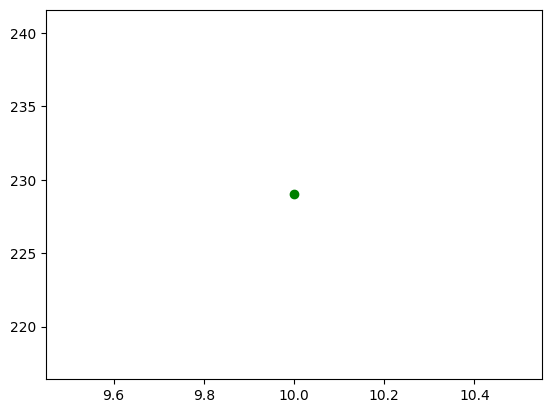

Local Minima:  (11, 13)


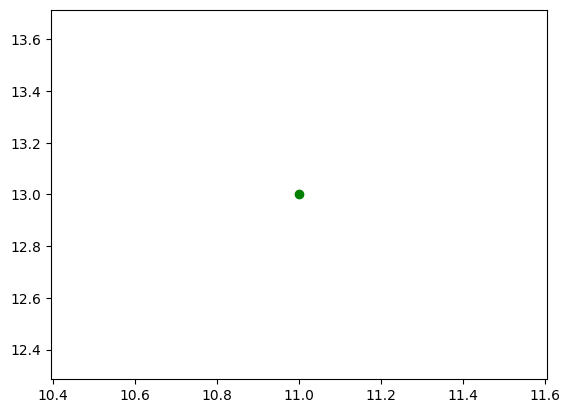

Local Minima:  (85, 17)


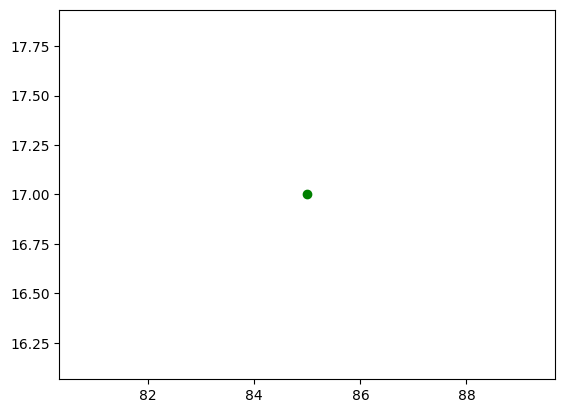

Local Minima:  (92, 175)


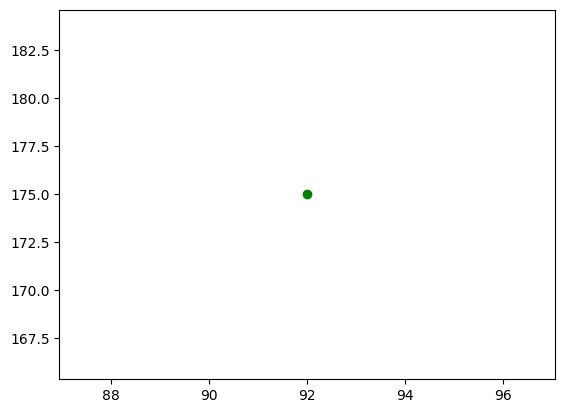

Local Minima:  (98, 11)


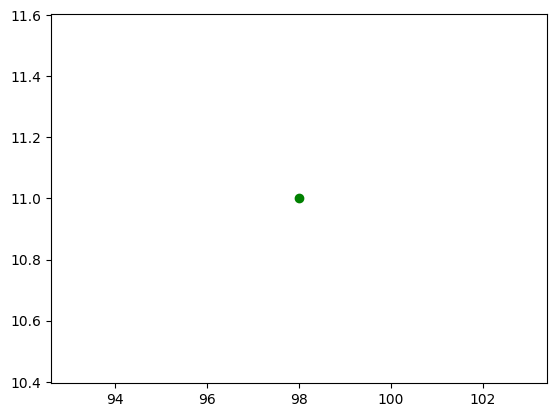

Local Minima:  (104, 71)


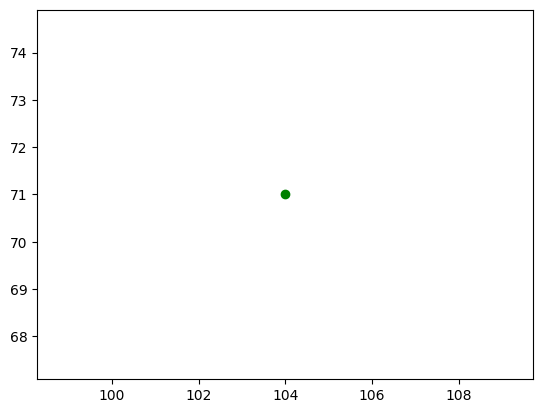

Local Minima:  (125, 169)


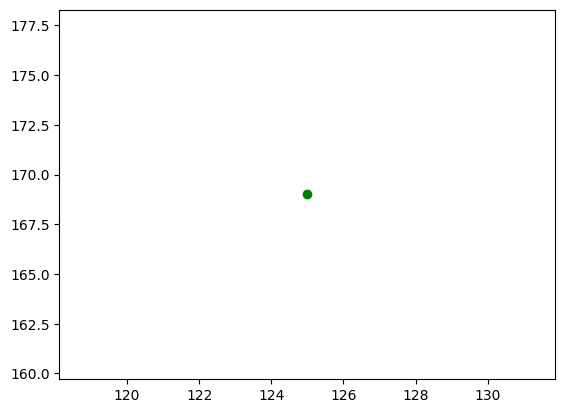

Local Minima:  (129, 43)


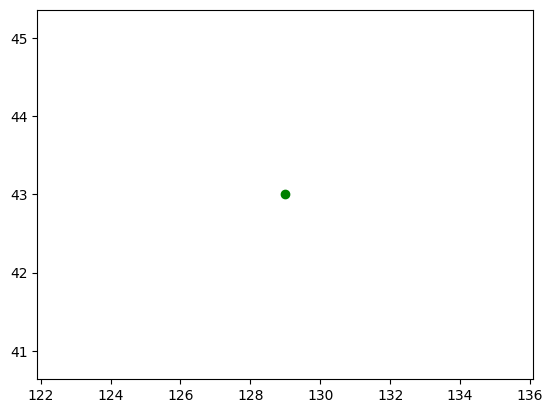

Local Minima:  (147, 35)


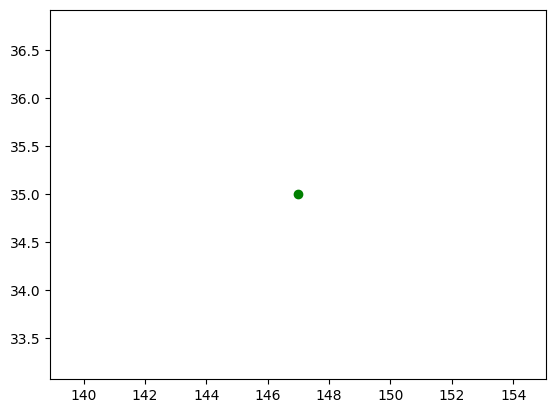

Local Minima:  (149, 169)


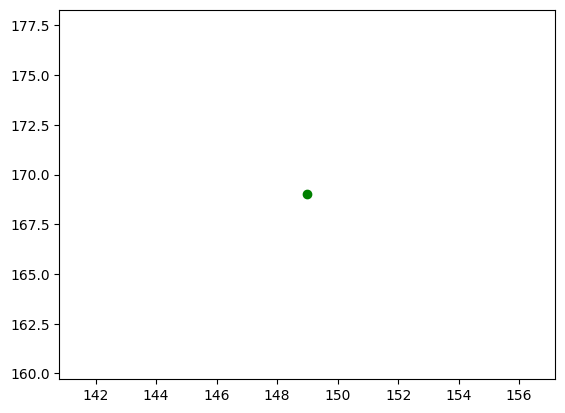

Local Minima:  (150, 249)


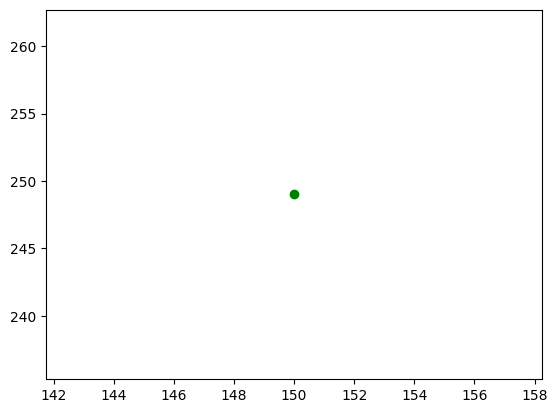

Local Minima:  (168, 249)


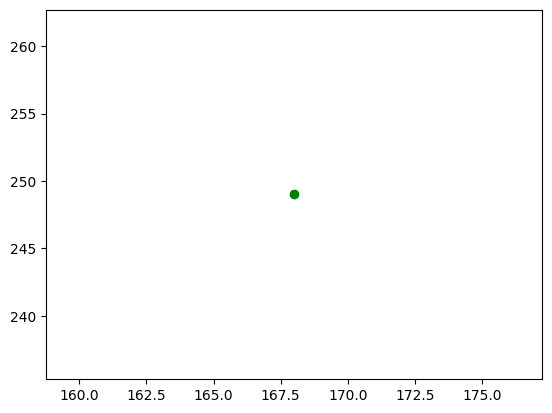

Local Minima:  (175, 67)


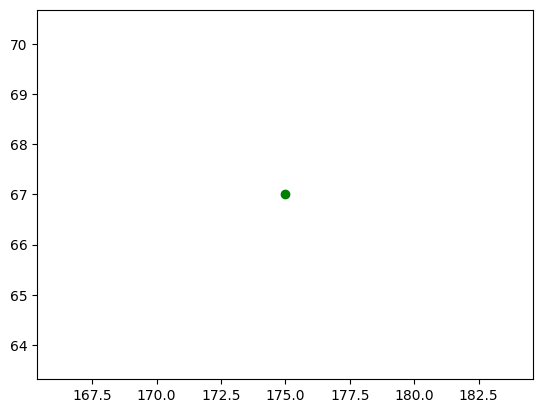

Local Minima:  (224, 17)


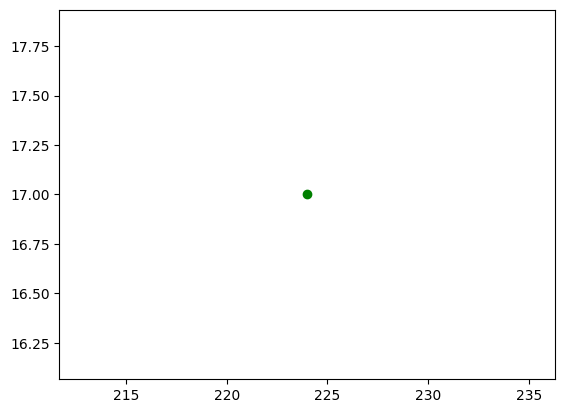

Local Minima:  (226, 178)


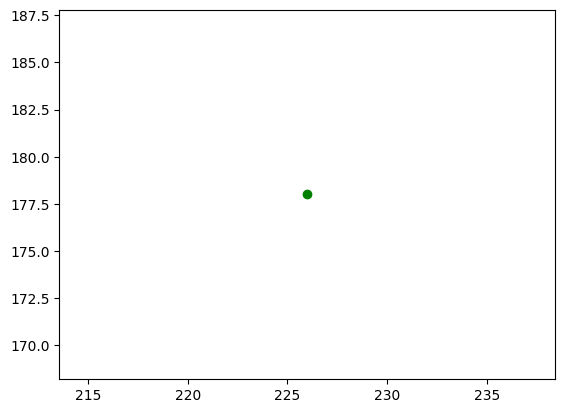

Local Minima:  (249, 29)


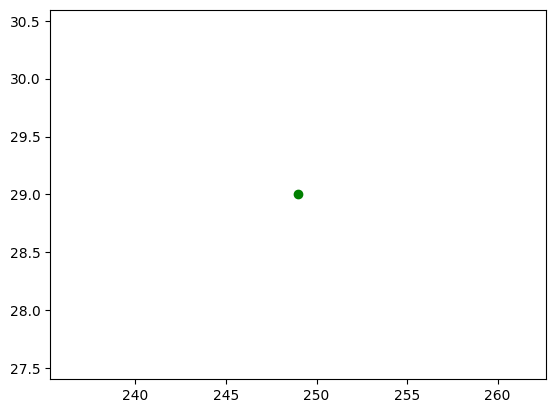

In [71]:
three_dim_matrices = csv_to_3D_matrix(folder_path=folder_path, csv_files=csv_files)
local_minima_per_matrix = [find_local_minima(i) for i in three_dim_matrices]
local_maxima_per_matrix = [find_local_maxima(i) for i in three_dim_matrices]

for i in range(len(three_dim_matrices)):
  # energy_levels = pd.read_csv(os.path.join(folder_path, csv_files[i]), header=None, names=['x', 'y', 'Value'])
  # heat_map = energy_levels.pivot(index='y', columns='x', values='Value')
  # sns.heatmap(heat_map, cmap='magma', annot=False, fmt=".1f")

  sns.heatmap(three_dim_matrices[i], cmap='magma', annot=False, fmt=".1f")
  for j in local_minima_per_matrix[i]:
    plt.scatter(x=j[0], y=j[1], color='green', marker='o')
    print("Local Minima: ", j)
    
  for k in local_minima_per_matrix[i]:
    print(k)

  plt.show()
